In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Utility Functions

In [ ]:
def get_dummies_genre(df, target_col='Genre'):
    """
    Function to create one hot encodings for a target_col (splits the values into separate encodings).
    Param: df: the dataframe with the target column.
           target_col: the target column to create one hot encodings.
    """
    df[target_col] = df[target_col].str.strip().str.lower()
    df[target_col] = df[target_col].str.replace(',', '')
    df[target_col] = df[target_col].str.replace(".", '')
    df[target_col] = df[target_col].str.replace("  ", ' ')
    genre_values = df[target_col].unique().tolist()
    genre_values = [str(value).split(" ") for value in genre_values]
    genre_values = [item for sublist in genre_values for item in sublist]
    genre_values = list(set(genre_values))
    # print(genre_values)
    corrections = {
        'famiily': 'family',
        'horro': 'horror',
        'thriler': 'thriller',
        'sport': 'sports',
        'romantic': 'romance'
    }
    genre_values = [corrections[name] if name in corrections else name for name in genre_values]
    genre_values = list(set(genre_values))
    # print(genre_values)

    df[target_col] = df[target_col].replace(corrections)

    for genre in genre_values:
        df[target_col+"_"+genre] = (df[target_col].apply(lambda x: genre in str(x).split(" "))).astype(int)

    df.drop(columns=[target_col], inplace=True)

In [ ]:
def combine_primary_genre(df):
    """Function that combines the columns 'Primary Genre' and 'Genre'."""
    df['Primary Genre'].fillna('', inplace=True)
    df['Genre'] = df['Genre'] + ', ' + df['Primary Genre']
    df['Genre'] = df['Genre'].str.lstrip(', ')
    df.drop(columns=['Primary Genre'], inplace=True)

# Part 1: Data Preparation

## Preprocess & Collect Movies data:

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import json
import re

import matplotlib.pyplot as plt

!pip install PyMovieDb > /dev/null 2>&1
from PyMovieDb import IMDB

Loading Data

In [ ]:
df = pd.read_excel('/content/drive/My Drive/DataMining/movies.xlsx')
print(df.shape)

(1402, 31)


Στατιστικά από τις αριθμητικές και τις κατηγορικές μεταβλητές

In [ ]:
# Summary statistics for numerical variables
print(df.describe().T)

print("=====================================================================")

# Summary statistics for categorical variables
print(df.describe(include='object').T)

                             count         mean         std     min  \
Year                        1402.0  2012.140514    3.190291  2007.0   
Rotten Tomatoes Audience    1401.0    62.122769   17.435737    17.0   
Opening weekend ($million)  1402.0    23.200357   28.547541     0.0   
Domestic gross ($million)   1402.0    74.058024   87.389737     0.0   
Worldwide Gross ($million)  1402.0   173.008302  233.859025     0.0   
Distributor                    0.0          NaN         NaN     NaN   
IMDb Rating                    0.0          NaN         NaN     NaN   
IMDB vs RT disparity           0.0          NaN         NaN     NaN   

                                  25%       50%        75%      max  
Year                        2009.0000  2012.000  2015.0000  2017.00  
Rotten Tomatoes Audience      49.0000    62.000    76.0000    98.00  
Opening weekend ($million)     6.6025    14.200    28.5975   247.97  
Domestic gross ($million)     21.0900    44.045    92.5900   936.66  
Worldwide 

We see the persentages of the missing values.

In [ ]:
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100
missing_percentage.sort_values(ascending=True, inplace=True)
print(missing_percentage)

Rotten Tomatoes  critics       0.071327
Rotten Tomatoes Audience       0.071327
Genre                          0.071327
Oscar Winners                 96.005706
Oscar Detail                  96.005706
Primary Genre                 98.644793
Distributor                  100.000000
IMDb Rating                  100.000000
IMDB vs RT disparity         100.000000
dtype: float64


We drop the columns that have no values (we will fill them afterwards):

In [ ]:
df.drop(columns=['IMDb Rating', 'IMDB vs RT disparity', 'Distributor'], inplace=True)

Download IMDb TSV files for more movie info ([source](https://datasets.imdbws.com/)):

In [ ]:
!wget https://datasets.imdbws.com/title.ratings.tsv.gz
!gunzip -f title.ratings.tsv.gz
!wget https://datasets.imdbws.com/title.basics.tsv.gz
!gunzip -f title.basics.tsv.gz

--2024-01-15 08:35:11--  https://datasets.imdbws.com/title.ratings.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.226.210.101, 13.226.210.25, 13.226.210.114, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.226.210.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6997438 (6.7M) [binary/octet-stream]
Saving to: ‘title.ratings.tsv.gz’

title.ratings.tsv.g 100%[===================>]   6.67M  38.7MB/s    in 0.2s    

2024-01-15 08:35:11 (38.7 MB/s) - ‘title.ratings.tsv.gz’ saved [6997438/6997438]

--2024-01-15 08:35:11--  https://datasets.imdbws.com/title.basics.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.226.210.101, 13.226.210.25, 13.226.210.114, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.226.210.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 183394470 (175M) [binary/octet-stream]
Saving to: ‘title.basics.tsv.gz’

title.basics.tsv.gz 100%[==================

Changing and Saving the data to our custom dataframe:

In [ ]:
df_ratings = pd.read_csv('/content/title.ratings.tsv', sep='\t')

df_titles = pd.read_csv('/content/title.basics.tsv', sep='\t', low_memory=False)

df_titles = df_titles[df_titles['titleType'] == 'movie']

df_titles.drop(columns=['endYear', 'titleType', 'originalTitle'], inplace=True)

df_titles['startYear'] = pd.to_numeric(df_titles['startYear'], errors='coerce')

df_titles['startYear'] = df_titles['startYear'].astype('Int64')

# remove titles < 2006 (some movie in movies.xlsx where made in 2006 according to IMDb):
df_titles = df_titles[df_titles['startYear'] >= 2006]

df_titles.drop(columns=['genres'], inplace=True)

df_ratings['tconst'] = df_ratings['tconst'].astype(str)
df_titles['tconst'] = df_titles['tconst'].astype(str)

df_ratings['tconst'] = df_ratings['tconst'].str.strip()
df_ratings['tconst'] = df_ratings['tconst'].str.lower()

df_titles['tconst'] = df_titles['tconst'].str.strip()
df_titles['tconst'] = df_titles['tconst'].str.lower()

df_imdb = pd.merge(df_titles, df_ratings, on='tconst', how='inner')

df_imdb.drop(columns=["numVotes", "isAdult", "runtimeMinutes"], inplace=True)

df_imdb.rename(columns={'primaryTitle': 'Film', 'averageRating':'IMDb Rating', 'startYear':'Year'}, inplace=True)

df_imdb.drop(columns=['tconst'], inplace=True)

print(df_imdb)

                                                     Film  Year  IMDb Rating
0                             Istoriya grazhdanskoy voyny  2021          6.8
1                                       Shipmates o' Mine  2022          4.2
2       The Tango of the Widower and Its Distorting Mi...  2020          6.4
3                              The Other Side of the Wind  2018          6.7
4                                       Socialist Realism  2023          7.5
...                                                   ...   ...          ...
151388                                              Coven  2020          6.4
151389                                The Secret of China  2019          3.4
151390                                Kuambil Lagi Hatiku  2019          8.6
151391                                    Dankyavar Danka  2013          7.6
151392                                             6 Gunn  2017          7.6

[151393 rows x 3 columns]


Merge with custom dataset that contains IMDb Ratings and IMDb ids:

In [ ]:
# df_imdb = pd.read_excel('/content/movies_imdb.xlsx')
df_imdb['Film'] = df_imdb['Film'].astype(str)
df_imdb['Film'] = df_imdb['Film'].str.lower()

df['Film'] = df['Film'].astype(str)
df['Film'] = df['Film'].str.lower()
df['Film'] = df['Film'].str.rstrip()

merged_df = df.merge(df_imdb, on=['Film', 'Year'], how='left')

# missing because movies in movies.xlsx have different years than imdb.
missing_rows = merged_df[merged_df[['IMDb Rating']].isnull().any(axis=1)]

for index, row in missing_rows.iterrows():
    name = str(row['Film'])

    row_imdb = df_imdb.loc[df_imdb['Film'] == name]
    row_movies = merged_df.loc[merged_df['Film'] == name]

    if not row_imdb.empty:
        merged_df.at[row_movies.index[0], 'IMDb Rating'] = row_imdb['IMDb Rating'].values[0]

In [ ]:
missing_data = merged_df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / merged_df.shape[0]) * 100
missing_percentage.sort_values(ascending=True, inplace=True)
print(missing_percentage)

Rotten Tomatoes  critics      0.069930
Rotten Tomatoes Audience      0.069930
Genre                         0.069930
IMDb Rating                   7.552448
Oscar Winners                95.874126
Oscar Detail                 95.874126
Primary Genre                98.671329
dtype: float64


We find the duplicate rows and remove them:

In [ ]:
merged_df = merged_df.drop_duplicates()
merged_df = merged_df.drop_duplicates(subset='Film', keep='first')

We find the rows with missing values. After that we delete them.

In [ ]:
# Drop rows with missing values from the DataFrame
merged_df.dropna(subset=['Genre', 'Rotten Tomatoes  critics', 'Metacritic  critics', 'Metacritic Audience ', 'Rotten Tomatoes Audience '], inplace=True)
merged_df = merged_df[~(merged_df[['Genre', 'Rotten Tomatoes  critics', 'Metacritic  critics', 'Metacritic Audience ', 'Rotten Tomatoes Audience ']] == '-').any(axis=1)]

Webscrape the missing IMDb rating and tconst values:

In [ ]:
missing_rows = merged_df[merged_df[['IMDb Rating']].isnull().any(axis=1)]

imdb = IMDB()

for index, row in missing_rows.iterrows():
    film = str(row['Film'])

    try:
        imdb_data = json.loads(imdb.get_by_name(film, tv=False))
        imdb_rating = imdb_data.get('rating').get('ratingValue')

        merged_df.at[index, 'IMDb Rating'] = imdb_rating

        print(f"Film '{film}': IMDb Rating = {imdb_rating}")
    except Exception as e:
        print(f"Film '{film}' not found.")

df = merged_df

Film 'alien vs. predator - requiem': IMDb Rating = 5.7
Film 'dragon wars (aka d-war)' not found.
Film 'hostel part ii': IMDb Rating = 5.5
Film 'i now pronounce you chuck and larry': IMDb Rating = 5.9
Film 'ocean's 13' not found.
Film 'pathfinder: legend of the ghost warrior': IMDb Rating = 5.4
Film 'tyler perry's daddy's little girls': IMDb Rating = 5.8
Film 'tyler perry's why did i get married': IMDb Rating = 5.9
Film 'wall-e': IMDb Rating = 8.3
Film '10,000 b.c.': IMDb Rating = 5.1
Film 'dr. seuss' horton hears a who!': IMDb Rating = 6.8
Film 'marley and me': IMDb Rating = 7
Film 'the x-files: i want to believe': IMDb Rating = 5.9
Film 'pride & glory': IMDb Rating = 7.8
Film 'tyler perry's meet the browns': IMDb Rating = 6.2
Film 'be kind, rewind': IMDb Rating = 6.4
Film 'the boy in the striped pyjamas': IMDb Rating = 7.7
Film 'harold and kumar escape from guantanamo bay': IMDb Rating = 6.5
Film 'tyler perry's the family that preys': IMDb Rating = 5.9
Film 'the taking of pelham 1 2 3

Change names for better webscraping:

In [ ]:
df['Film_Scrape'] = df['Film']

df['Film_Scrape'] = df['Film_Scrape'].str.replace('!', '')
df['Film_Scrape'] = df['Film_Scrape'].str.replace("'", '')
df['Film_Scrape'] = df['Film_Scrape'].str.replace("’", '')
df['Film_Scrape'] = df['Film_Scrape'].str.replace('(', '')
df['Film_Scrape'] = df['Film_Scrape'].str.replace(')', '')
df['Film_Scrape'] = df['Film_Scrape'].str.replace('&', 'and')
df['Film_Scrape'] = df['Film_Scrape'].str.replace(':', '')
df['Film_Scrape'] = df['Film_Scrape'].str.replace(' ', '_')
df['Film_Scrape'] = df['Film_Scrape'].str.replace('. ', '_')
# df['Film_Scrape'] = df['Film_Scrape'].str.replace('.', '')
df['Film_Scrape'] = df['Film_Scrape'].str.replace('.', '_')
df['Film_Scrape'] = df['Film_Scrape'].str.replace(',', '')
# df['Film_Scrape'] = df['Film_Scrape'].str.replace('-', '')
df['Film_Scrape'] = df['Film_Scrape'].str.replace('-', '_')

df['Film_Scrape'] = df['Film_Scrape'].str.replace('/', '')
df['Film_Scrape'] = df['Film_Scrape'].str.replace('_ii', '_2')
df['Film_Scrape'] = df['Film_Scrape'].str.replace('_iii', '_3')
df['Film_Scrape'] = df['Film_Scrape'].str.replace('_iv', '_4')

df['Film_Scrape'] = df['Film_Scrape'].str.replace('__', '_')
df['Film_Scrape'] = df['Film_Scrape'].str.replace('__', '_')
df['Film_Scrape'] = df['Film_Scrape'].str.replace('___', '_')
df['Film_Scrape'] = df['Film_Scrape'].str.replace('_$', '')

Collect Distributors for each movie via webscrape from rotten tomatoes:

In [ ]:
import requests
from bs4 import BeautifulSoup

def get_distributor(film, year):
    req = requests.get("https://www.rottentomatoes.com/m/" + film)
    if req.status_code != 200:
        req = requests.get("https://www.rottentomatoes.com/m/" + film + "_" + str(year)) # tries with the year at the end.
        if req.status_code != 200:
            if film[:4] != 'the_':
                print(f'Film "{film}" distributor not found!')
                return np.nan
            film = film[4:] # tries without "the" in front:
            req = requests.get("https://www.rottentomatoes.com/m/" + film)
            if req.status_code != 200:
                print(f'Film "{film}" distributor not found!')
                return np.nan

    content = req.text
    soup = BeautifulSoup(content, 'html.parser')
    distributor_label = soup.find('b', string='Distributor:')

    distributor = np.nan

    if distributor_label:
        distributor = distributor_label.find_next_sibling('span').get_text(strip=True)
        distributor = ' '.join(distributor.strip().split())
        return distributor.lower().strip()  # Convert to lowercase & Remove trailing whitespace

    # film does not have distributor.
    return -1

df['Distributor'] = df.apply(lambda row: get_distributor(row['Film_Scrape'], row['Year']), axis=1)
df.drop(columns=['Film_Scrape'], inplace=True)
print(df)

Film "alien_vs_predator_requiem" distributor not found!
Film "dragon_wars_aka_d_war" distributor not found!
Film "hostel_part_2" distributor not found!
Film "oceans_13" distributor not found!
Film "p_s_i_love_you" distributor not found!
Film "pathfinder_legend_of_the_ghost_warrior" distributor not found!
Film "spider_man_3" distributor not found!
Film "game_plan" distributor not found!
Film "transformers" distributor not found!
Film "tyler_perrys_daddys_little_girls" distributor not found!
Film "walk_hard_the_dewey_cox_story" distributor not found!
Film "10000_b_c" distributor not found!
Film "step_brothers" distributor not found!
Film "superhero_movie" distributor not found!
Film "babylon_a_d" distributor not found!
Film "soul_men" distributor not found!
Film "space_chimps" distributor not found!
Film "untraceable" distributor not found!
Film "what_happens_in_vegas" distributor not found!
Film "x_files_i_want_to_believe" distributor not found!
Film "igor" distributor not found!
Film "

In [ ]:
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100
missing_percentage.sort_values(ascending=True, inplace=True)
print(missing_percentage)

Deleting some unnecessary columns

In [ ]:
# df.drop(columns=['Average critics '], inplace=True) # prokiptei apo Rotten Tomatoes  critics + Metacritic  critics / 2

# df.drop(columns=['Average audience '], inplace=True)  # prokiptei apo Metacritic Audience + Rotten Tomatoes Audience  / 2

# df.drop(columns=['Rotten Tomatoes vs Metacritic  deviance'], inplace=True)  # prokiptei apo Rotten Tomatoes Audience - Metacritic Audience

# df.drop(columns=['Worldwide Gross'], inplace=True)   # prokiptei apo to Domestic Gross + Foreign Gross
# df.drop(columns=['Release Date (US)'], inplace=True) # Kratame to Year
# df.drop(columns=['Primary Genre'], inplace=True)  # epanalanvanetai sto genre kai exei polla nulls

# df.drop(columns=['Audience vs Critics deviance '], inplace=True)  # prokiptei apo round((Rotten Tomatoes  critics + Metacritic  critics / 2) - (Metacritic Audience + Rotten Tomatoes Audience  / 2))

# df.drop(columns=[' of Gross earned abroad'], inplace=True)  # prokiptei apo to Foreign Gross / (Foreign Gross + Domestic gross)

# df.drop(columns=[' Budget recovered opening weekend'], inplace=True)  # prokiptei apo (Opening weekend / Budget) * 100

# df.drop(columns=[' Budget recovered'], inplace=True)  # prokiptei apo ((Foreign Gross + Domestic gross) / Budget) * 100

# IMDB vs RT disparity = Rotten Tomatoes Audience  - IMDb Rating * 10

# the following columns do have in millions the data:
df.drop(columns=['Worldwide Gross ($million)', 'Opening weekend ($million)', 'Domestic gross ($million)', 'Foreign Gross ($million)'], inplace=True)
df.drop(columns=['Oscar Detail'], inplace=True) # drops column since it is not in sample dataset.
combine_primary_genre(df) # combines the primary genre with genre.

Fill Oscars (0 or 1), IMDb Ratings & Distributors

In [ ]:
df['Oscar Winners'] = df['Oscar Winners'].map({'Oscar winner': 1, 'Oscar Winner':1})
df['Oscar Winners'].fillna(0, inplace=True)

df['Distributor'].fillna(-1, inplace=True) # assumes that the 6.98% of films do not have distributor.
df['Average audience '] = pd.to_numeric(df['Average audience '])

diff = df['Average audience '] - df['IMDb Rating'] * 10
mean_difference = diff.mean()
print("Mean IMDB vs RT disparity:", mean_difference)
missing_imdb = df[df['IMDb Rating'].isnull()]
missing_imdb['IMDb Rating'] = (missing_imdb['Average audience '] - mean_difference) / 10
df.update(missing_imdb)

df['IMDB vs RT disparity'] = df['Rotten Tomatoes Audience '] - df['IMDb Rating'] * 10


In [ ]:
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100
missing_percentage.sort_values(ascending=True, inplace=True)
print(missing_percentage)

Μετατροπή κατηγορικών μεταβλητών σε αριθμητικές

In [ ]:
df['Rotten Tomatoes  critics'] = pd.to_numeric(df['Rotten Tomatoes  critics'])
df['Metacritic  critics'] = pd.to_numeric(df['Metacritic  critics'])
df['Metacritic Audience '] = pd.to_numeric(df['Metacritic Audience '])

df['Opening Weekend'] = pd.to_numeric(df["Opening Weekend"].replace(',', '', regex=True))
df['Domestic Gross'] = pd.to_numeric(df["Domestic Gross"].replace(',', '', regex=True))
df['Foreign Gross'] = pd.to_numeric(df["Foreign Gross"].replace(',', '', regex=True))

# Create Budget Column:
df["Budget ($million)"] = df["Budget ($million)"].replace('-', np.nan)
df.dropna(subset=["Budget ($million)"], inplace=True)
df["Budget ($million)"] = pd.to_numeric(df["Budget ($million)"])
df["Budget"] = df["Budget ($million)"] * 1_000_000
df.dropna(subset=["Budget"], inplace=True)

df.drop(columns=['Budget ($million)'], inplace=True)

df['Rotten Tomatoes vs Metacritic  deviance'] = pd.to_numeric(df['Rotten Tomatoes vs Metacritic  deviance'])
df['Audience vs Critics deviance '] = pd.to_numeric(df['Audience vs Critics deviance '])
df['Average critics '] = pd.to_numeric(df['Average critics '])
df['Average audience '] = pd.to_numeric(df['Average audience '])
df['Worldwide Gross'] = pd.to_numeric(df['Worldwide Gross'].replace(',', '', regex=True))
df['Worldwide Gross'] = pd.to_numeric(df['Worldwide Gross'])

df[' of Gross earned abroad'] = pd.to_numeric(df[" of Gross earned abroad"].replace('%', '', regex=True))
df[' Budget recovered'] = pd.to_numeric(df[" Budget recovered"].replace('%', '', regex=True))
df[' Budget recovered opening weekend'] = pd.to_numeric(df[" Budget recovered opening weekend"].replace('%', '', regex=True))


In [ ]:
print(df.shape)
# Summary statistics for categorical variables
print(df.describe(include='object').T)

In [ ]:
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100
missing_percentage.sort_values(ascending=True, inplace=True)
print(missing_percentage)

In [ ]:
df.to_excel('/content/drive/My Drive/DataMining/movies_tmp_test.xlsx', index=False)


## Feature Selection:

Plotting the correlation of the script type and genre.

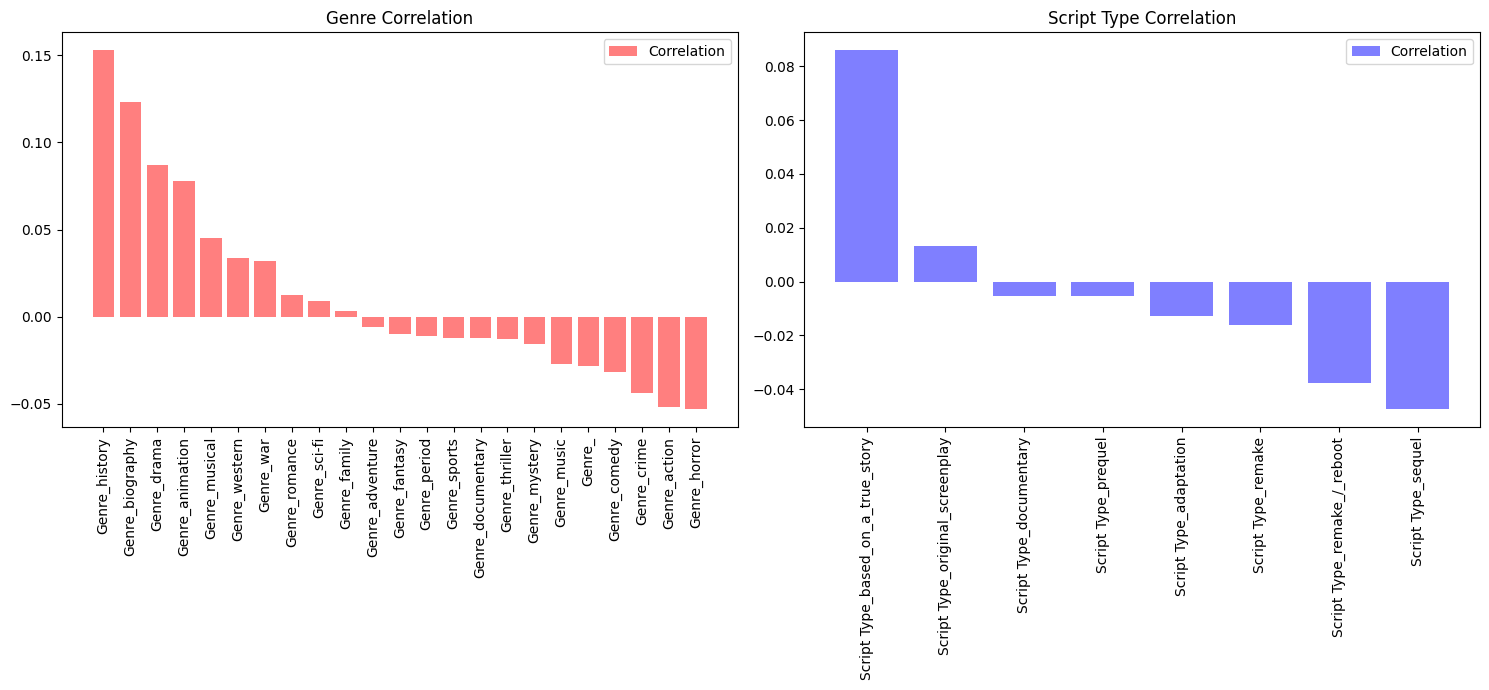

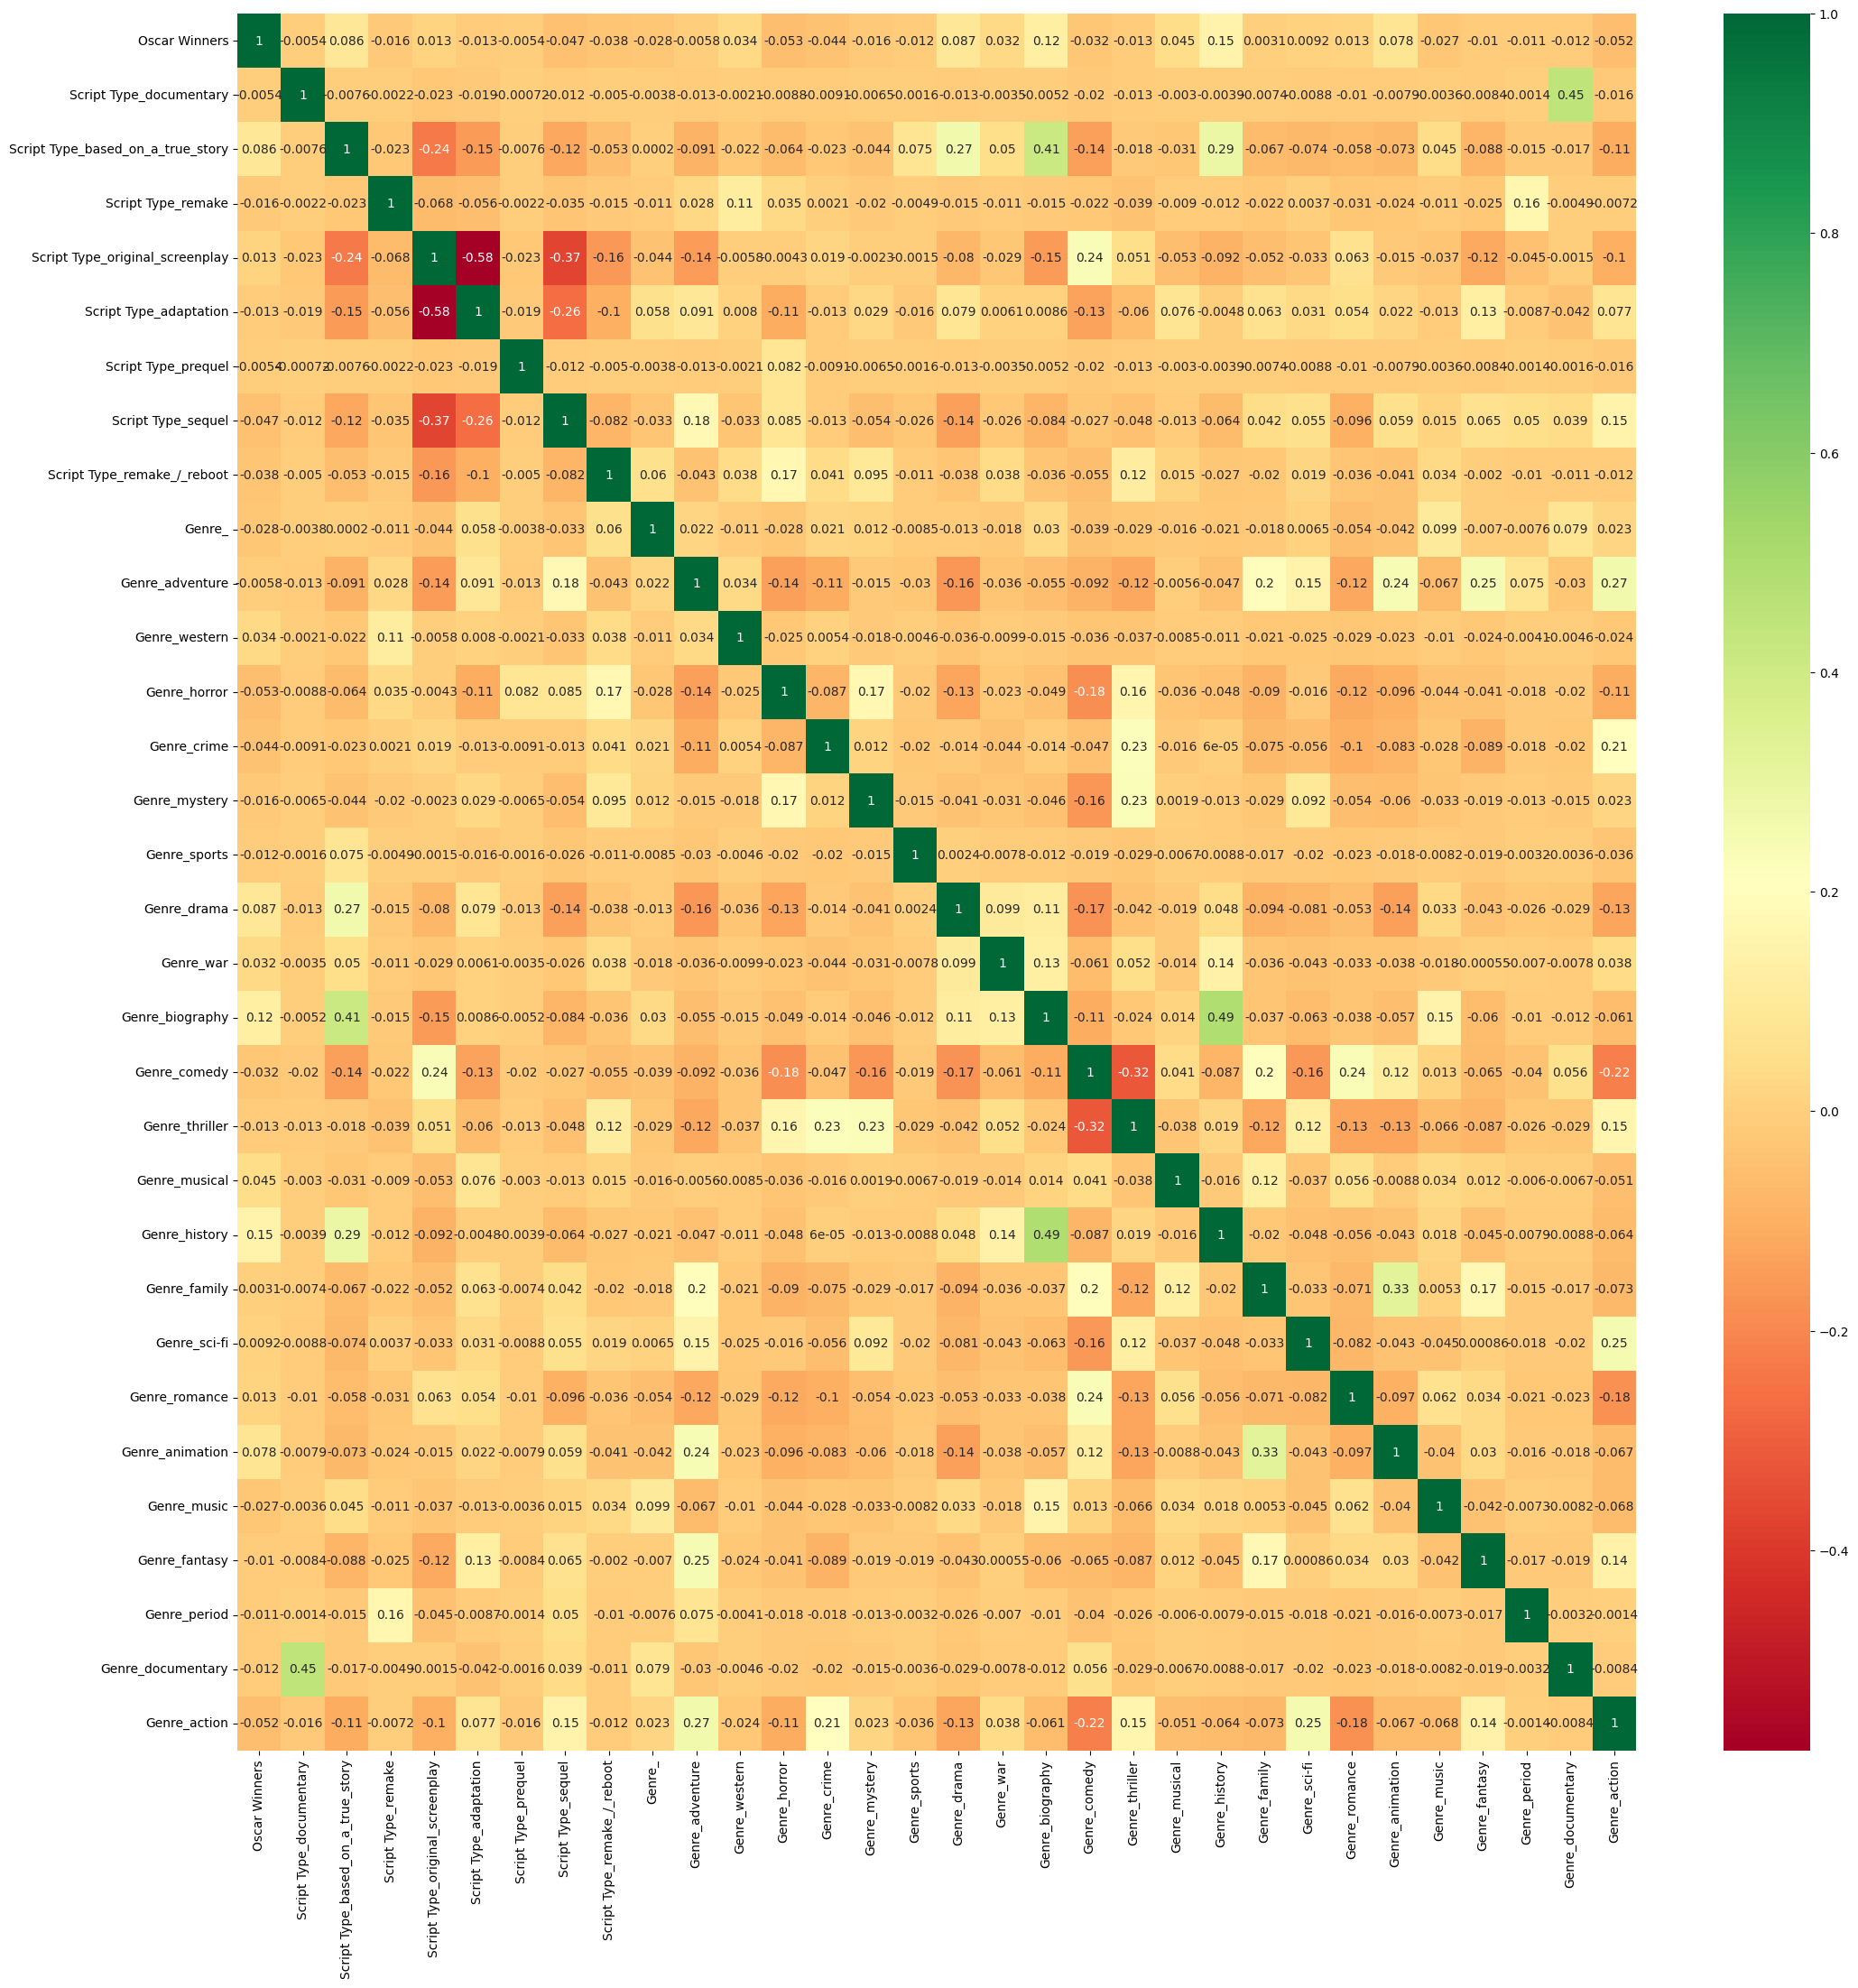

In [ ]:
import pandas as pd
df_oscar = pd.read_excel('/content/drive/My Drive/DataMining/movies_tmp_test.xlsx')
# df_oscar = df_oscar[df_oscar['Oscar Winners'] == 1]

df_oscar = df_oscar[['Script Type', 'Genre', 'Oscar Winners']]

# Lowercase and strip whitespace from 'Script Type' and 'Genre' columns
columns_to_clean = ['Script Type', 'Genre']
for col in columns_to_clean:
    if col in df_oscar.columns:
        df_oscar[col] = df_oscar[col].str.strip().str.lower()


df_oscar['Script Type'] = df_oscar['Script Type'].str.strip()
df_oscar['Script Type'] = df_oscar['Script Type'].str.replace(' ', '_')
df_oscar['Script Type'] = df_oscar['Script Type'].str.replace(",_", ' ')
get_dummies_genre(df_oscar, 'Script Type')
get_dummies_genre(df_oscar)

l = {}
genre = {}
for col in df_oscar.columns:
    if col != 'Oscar Winners':  # Exclude 'Oscar Winners' column
        correlation = df_oscar['Oscar Winners'].corr(df_oscar[col])
        if col.startswith("Script Type"):
            l[col] = correlation
        else:
            genre[col] = correlation


import matplotlib.pyplot as plt
import numpy as np

# Print keys and their values in descending order of values
sorted_keys = sorted(genre, key=lambda x: genre[x], reverse=True)
values1 = [genre[key] for key in sorted_keys]

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0].bar(np.array(sorted_keys), np.array(values1), color='r', alpha=0.5, label='Correlation')
axs[0].set_title('Genre Correlation')
axs[0].set_xticks(np.arange(len(sorted_keys)))
axs[0].set_xticklabels(sorted_keys, rotation=90)
axs[0].legend()

# Print keys and their values in descending order of values
sorted_keys = sorted(l, key=lambda x: l[x], reverse=True)
values1 = [l[key] for key in sorted_keys]

axs[1].bar(np.array(sorted_keys), np.array(values1), color='b', alpha=0.5, label='Correlation')
axs[1].set_title('Script Type Correlation')
axs[1].set_xticks(np.arange(len(sorted_keys)))
axs[1].set_xticklabels(sorted_keys, rotation=90)
axs[1].legend()

plt.tight_layout()
plt.show()

import seaborn as sns
corrmat = df_oscar.corr()
top_corr_feat = corrmat.index
plt.figure(figsize=(25, 25))
g = sns.heatmap(df_oscar[top_corr_feat].corr(), annot=True, cmap='RdYlGn')

* Για την επιλογή των genre, παίρνουμε τις στήλες ['Genre_history', 'Genre_biography', 'Genre_drama', 'Genre_animation'], καθώς αυτές έχουν το μεγαλύτερο (κατά απόλυτη τιμή) correlation.
* Για την επιλογή του script type, επιλέγουμε τη στήλη ['Script Type_based on a true story'], καθώς αυτή έχει το μεγαλύτερο (κατά απόλυτη τιμή) correlation.

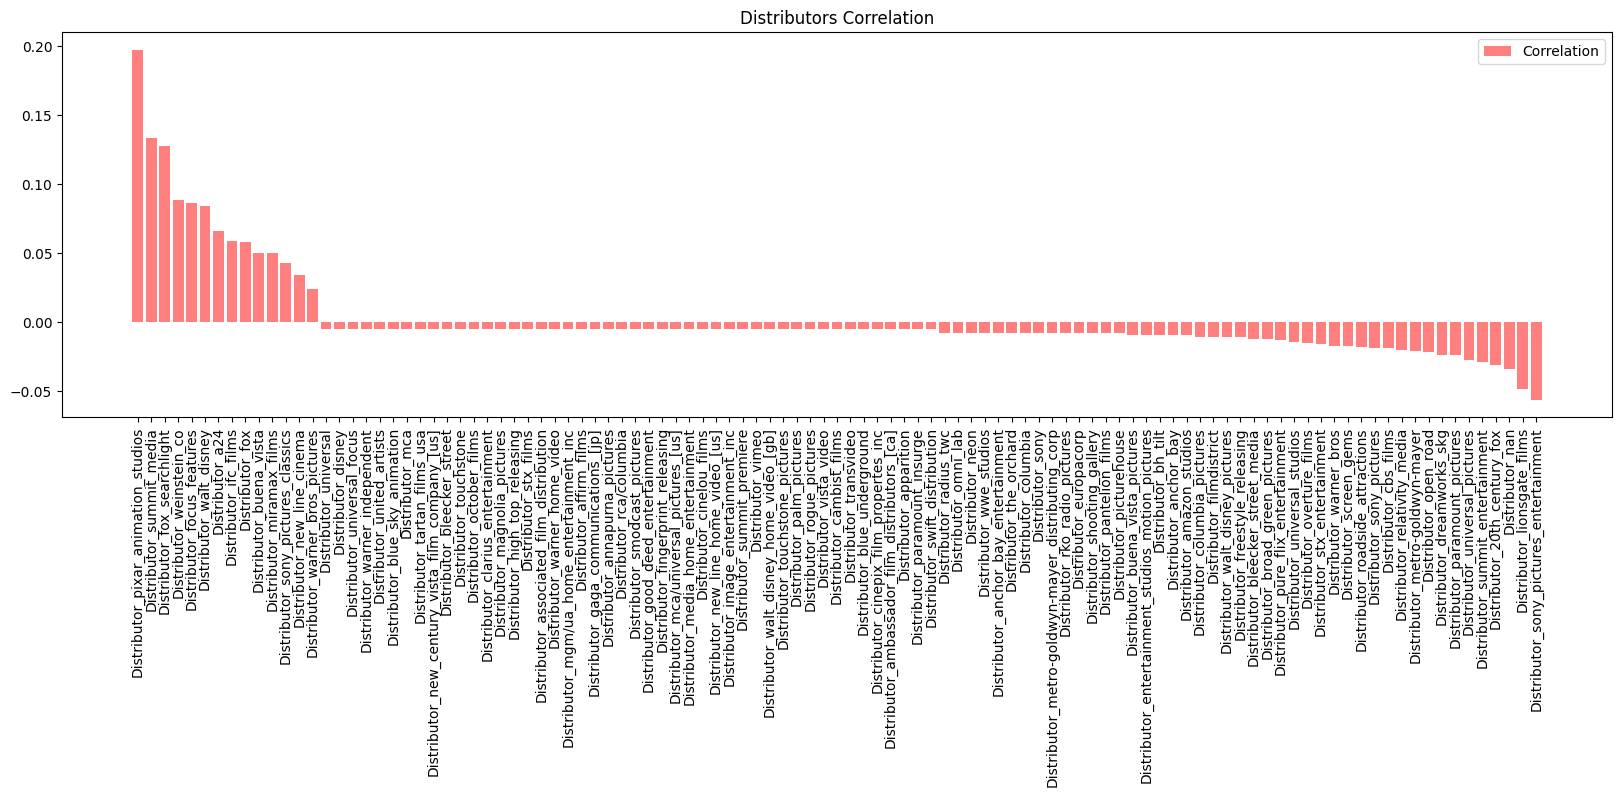

In [ ]:
import pandas as pd
df_oscar = pd.read_excel('/content/drive/My Drive/DataMining/movies_tmp_test.xlsx')

df_oscar = df_oscar[['Distributor', 'Oscar Winners']]
df_oscar['Distributor'] = df_oscar['Distributor'].str.replace(' ', '_')
df_oscar['Distributor'] = df_oscar['Distributor'].str.replace(",_", ' ')

get_dummies_genre(df_oscar, 'Distributor')

l = {}
for col in df_oscar.columns:
    if col != 'Oscar Winners':  # Exclude 'Oscar Winners' column
        correlation = df_oscar['Oscar Winners'].corr(df_oscar[col])
        l[col] = correlation

# Print keys and their values in descending order of values
sorted_keys = sorted(l, key=lambda x: l[x], reverse=True)

import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(20, 5)) # Set the figure size
values1 = [l[key] for key in sorted_keys]
plt.bar(np.array(sorted_keys), np.array(values1), color='r', alpha=0.5, label='Correlation')
plt.xticks(rotation=90)
plt.title('Distributors Correlation')
plt.legend()
plt.show()


Παρατηρούμε ότι οι στήλες ['Distributor_pixar_animation_studios', 'Distributor_summit_media', 'Distributor_fox_searchlight'] έχουν υψηλό correlation με το oscar winners, οπότε της επιλέγουμε.

Function for calculating feature importance:

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier

def calc_importance(df_oscar):
    X = df_oscar.drop('Oscar Winners', axis=1)
    y = df_oscar['Oscar Winners']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)

    importances_cervical = rf_classifier.feature_importances_

    feature_importance = list(zip(X.columns, importances_cervical))
    feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
    # Print feature names and their importance values
    d = {}
    for feature_name, importance in feature_importance:
        # print(f"{feature_name}: {importance}")
        d[feature_name] = importance
    return d


Plot Feature Importance:

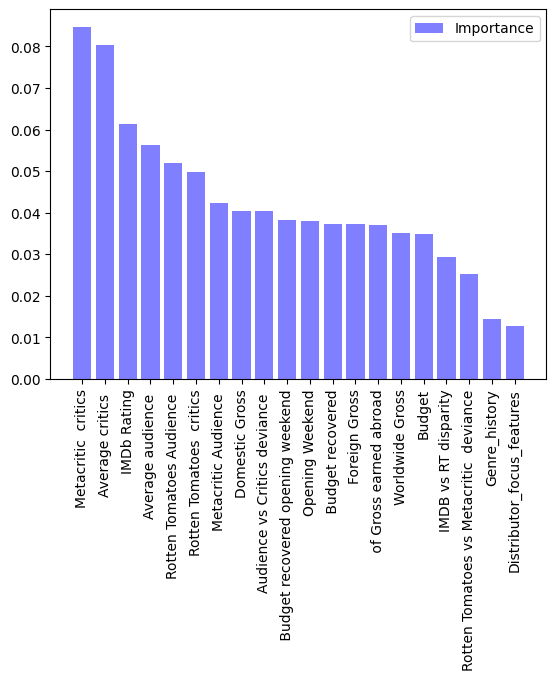

In [ ]:
import pandas as pd

df = pd.read_excel('/content/drive/My Drive/DataMining/movies_tmp_test.xlsx')

df.drop(columns=['Film', 'Year', 'Release Date (US)'], inplace=True)

df['Script Type'] = df['Script Type'].str.strip()
df['Script Type'] = df['Script Type'].str.replace(' ', '_')
df['Script Type'] = df['Script Type'].str.replace(",_", ' ')
get_dummies_genre(df, 'Script Type')

get_dummies_genre(df)

df['Distributor'] = df['Distributor'].str.replace(' ', '_')
df['Distributor'] = df['Distributor'].str.replace(",_", ' ')
get_dummies_genre(df, 'Distributor')

dict1 = calc_importance(df)

dict1 = {k: v for k, v in dict1.items() if v > 0.01}

import matplotlib.pyplot as plt
import numpy as np
values1 = [dict1[key] for key in list(dict1.keys())]
plt.bar(np.array(list(dict1.keys())), np.array(values1), color='b', alpha=0.5, label='Importance')
plt.xticks(rotation=90)

plt.legend()
plt.show()


Παρατηρούμε ότι οι στήλες ['Average critics ', 'Metacritic  critics', 'IMDb Rating', 'Rotten Tomatoes Audience ', 'Rotten Tomatoes  critics', 'Average audience '] είναι υψηλής σημαντικότητας.
<br>

**Παρατήρηση:** Μετά από πειραματισμό, θα τις επιλέξουμε όλες **εκτός** από την 'Average audience ', καθώς (οι υπόλοιπες) κάνουν καλύτερες προβλέψεις στο train / test set.

Συνεπώς οι στήλες που επιλέγουμε είναι: ['Average critics ','Metacritic  critics','IMDb Rating','Rotten Tomatoes Audience ', 'Oscar Winners', 'Rotten Tomatoes  critics', 'Script Type_based on a true story', 'Genre_history', 'Genre_biography', 'Genre_drama', 'Genre_animation', 'Distributor_pixar_animation_studios', 'Distributor_summit_media', 'Distributor_fox_searchlight']


In [ ]:
import pandas as pd

df = pd.read_excel('/content/drive/My Drive/DataMining/movies_tmp_test.xlsx')

df.drop(columns=['Film', 'Year', 'Release Date (US)'], inplace=True)

df['Script Type'] = df['Script Type'].str.strip()
df['Script Type'] = df['Script Type'].str.replace(' ', '_')
df['Script Type'] = df['Script Type'].str.replace(",_", ' ')
get_dummies_genre(df, 'Script Type')

get_dummies_genre(df)

df['Distributor'] = df['Distributor'].str.replace(' ', '_')
df['Distributor'] = df['Distributor'].str.replace(",_", ' ')
get_dummies_genre(df, 'Distributor')

# keys_list = ['Average critics ','Metacritic  critics','IMDb Rating','Rotten Tomatoes Audience ', 'Oscar Winners', 'Rotten Tomatoes  critics']

keys_list = ['Average critics ','Metacritic  critics','IMDb Rating','Rotten Tomatoes Audience ', 'Oscar Winners', 'Rotten Tomatoes  critics', 'Script Type_based_on_a_true_story', 'Genre_history', 'Genre_biography', 'Genre_drama', 'Genre_animation', 'Distributor_pixar_animation_studios', 'Distributor_summit_media', 'Distributor_fox_searchlight']
df = df[keys_list]

# normalize values:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df[keys_list] = scaler.fit_transform(df[keys_list])

Plot the selected features:

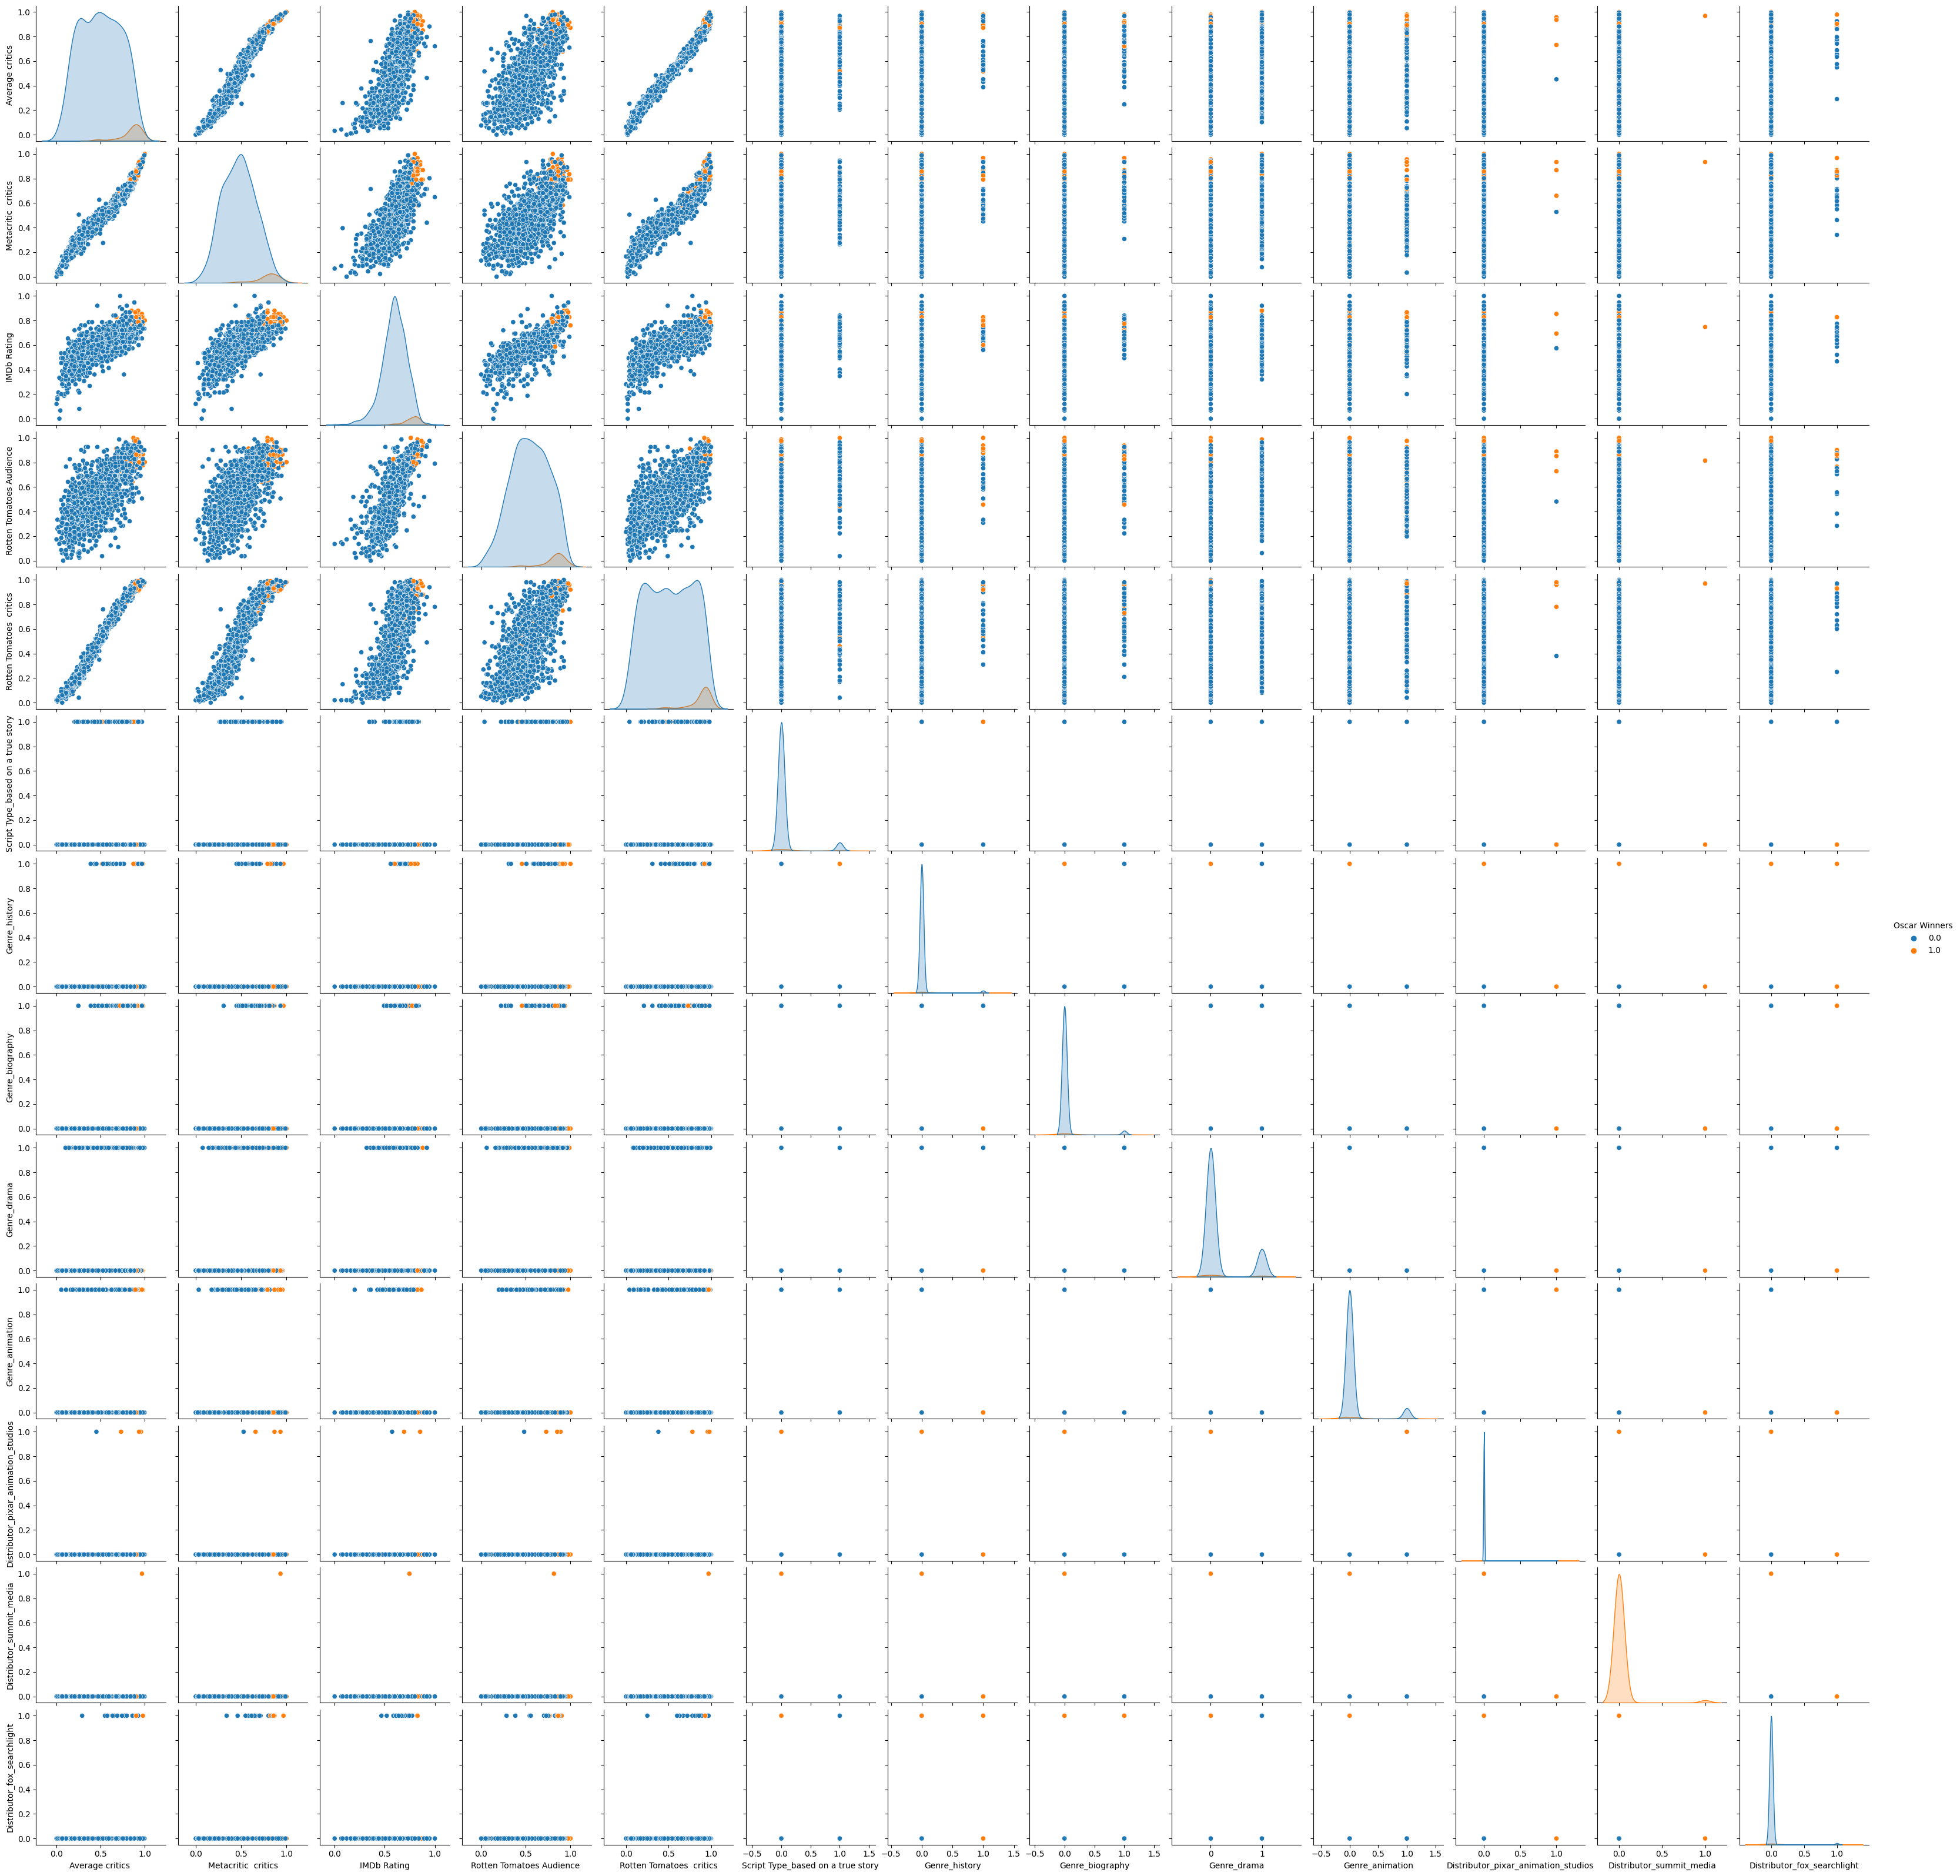

In [ ]:
import seaborn as sns

sns.pairplot(df, hue='Oscar Winners')

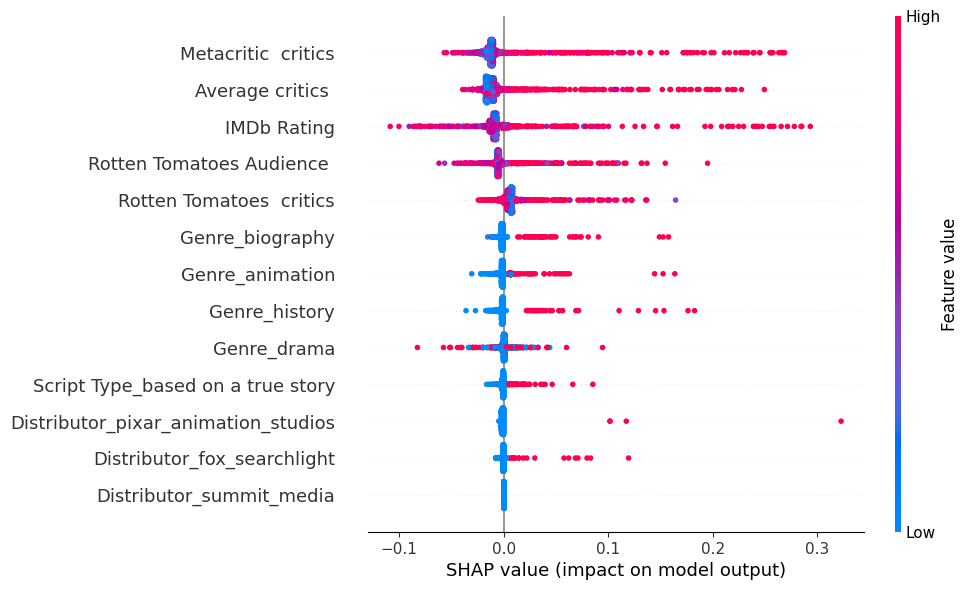

In [ ]:
!pip install shap > /dev/null 2>&1
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
X = df.drop('Oscar Winners', axis=1)
y = df['Oscar Winners']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

explainer = shap.Explainer(model)
shap_values = explainer(X)

# Visualize (SHAP-based) summary plot of the effects of all features for all dataset samples (global explanation)
shap.plots.beeswarm(shap_values[:,:,1], max_display=None) # retrieve shap values for Oscar Winners = 1.

Τα πιο σημαντικά features (σύμφωνα με το SHAP διάγραμμα αυτό) είναι αυτά που δεν είναι one-hot encodings (πχ Metacritic critics, Average critics κ.α). Βλέπουμε ότι όσο είναι "μεγάλα" αυτά τα values αυξάνουν (κυρίως) το αποτέλεσμα SHAP, δηλαδή τη πιθανότητα η ταινία να έχει πάρει oscar. Όταν όμως έχουν μεσαίες τιμές ή χαμηλώνουν μειώνεται (κυρίως) και η πιθανότητα να πάρουν oscar (στη πρόβλεψη).

Παρατηρούμε επίσης ότι για features με one-hot encodings (πχ Genre_biography, Genre_history κ.α) όταν είναι 1 (ψηλό value) αυξάνουν τη πιθανότητα να προβλεφθεί oscar (αντίστροφα όταν μειώνουμε το value των one-hot encodings). Είναι σημαντικό να σημειωθεί ότι η "ίδια" συμπεριφορά αναδεικνύεται και στα correlation plots, καθώς έχουν θετικό correlation με το oscar winners column και άρα μία "ομμόροπη" σχέση.

SMOTE (Synthetic Minority Over-sampling Technique): generates synthetic samples from the minority class to balance the data.

In [ ]:
!pip install -U imbalanced-learn > /dev/null 2>&1
from imblearn.over_sampling import SMOTE
import pandas as pd

X = df.drop('Oscar Winners', axis=1)
y = df['Oscar Winners']
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

y_res_series = pd.Series(y_res)

df = pd.concat([pd.DataFrame(X_res), y_res_series], axis=1)
print(df.shape)

count_oscars = (df['Oscar Winners'] == 1).sum()
print(f"Oscar Movies: {count_oscars}")

df = df.sample(frac=1, random_state=42).reset_index(drop=True)


(2660, 14)
Oscar Movies: 1330


Plot shap plots for Oscar Winners = 1 (after SMOTE - [source](https://stackoverflow.com/questions/76083485/shap-instances-that-have-more-than-one-dimension)):

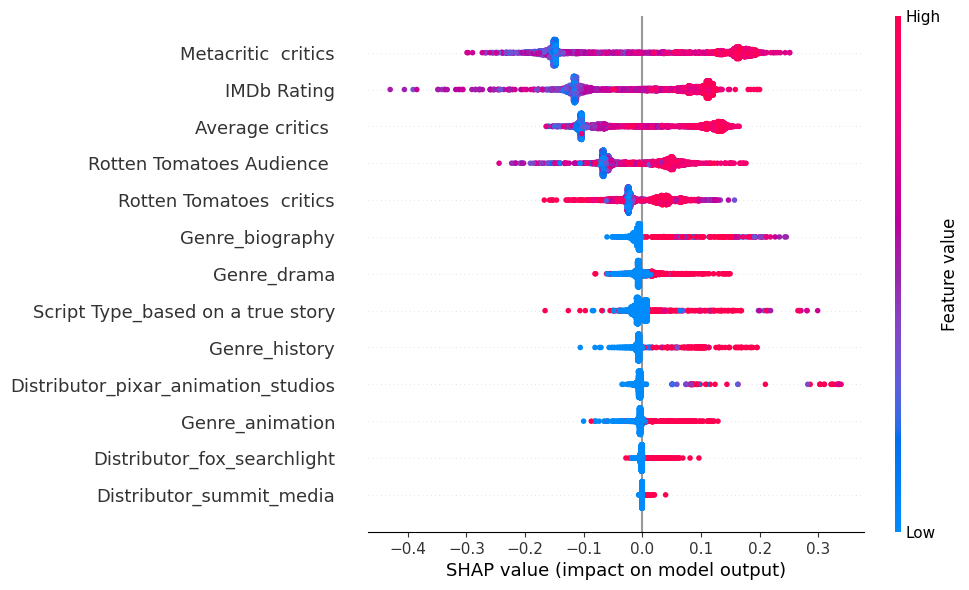

In [ ]:
!pip install shap > /dev/null 2>&1
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
X = df.drop('Oscar Winners', axis=1)
y = df['Oscar Winners']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

explainer = shap.Explainer(model)
shap_values = explainer(X)

# Visualize (SHAP-based) summary plot of the effects of all features for all dataset samples (global explanation)
shap.plots.beeswarm(shap_values[:,:,1], max_display=None) # retrieve shap values for Oscar Winners = 1.

Παρατηρούμε ότι τα αποτελέσματα είναι κοντά στο προηγούμενο SHAP (έχοντας όμως παραπάνω "δείγματα" από ταινίες με oscars).

Save xlsx:

In [ ]:
df.to_excel('/content/drive/My Drive/DataMining/moviesNew3.xlsx', index=False)
print(df.shape)

(2660, 14)


# Part 2: Predictions

Load the prepared df:

In [ ]:
df = pd.read_excel('/content/drive/My Drive/DataMining/moviesNew3.xlsx')
# df.drop(columns=['Film'], inplace=True) # not needed in training.

print(df.shape)
# df

(2660, 14)


In [ ]:
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100
missing_percentage.sort_values(ascending=True, inplace=True)
print(missing_percentage)
# Summary statistics for categorical variables
# print(df.describe(include='object').T)

Series([], dtype: float64)


Imports:

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score, classification_report, confusion_matrix, f1_score
import numpy as np

seed = 42 # Specify seed for better result debug.

K-fold cross validation can help avoid overfitting or underfitting by providing a more reliable estimate of the model's performance on unseen data. GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid, using k-fold cross-validation. Common k value is 10.

In [ ]:
k = 10

#### Using GridSearchCV:

Best Decision Tree min_samples_split: 2


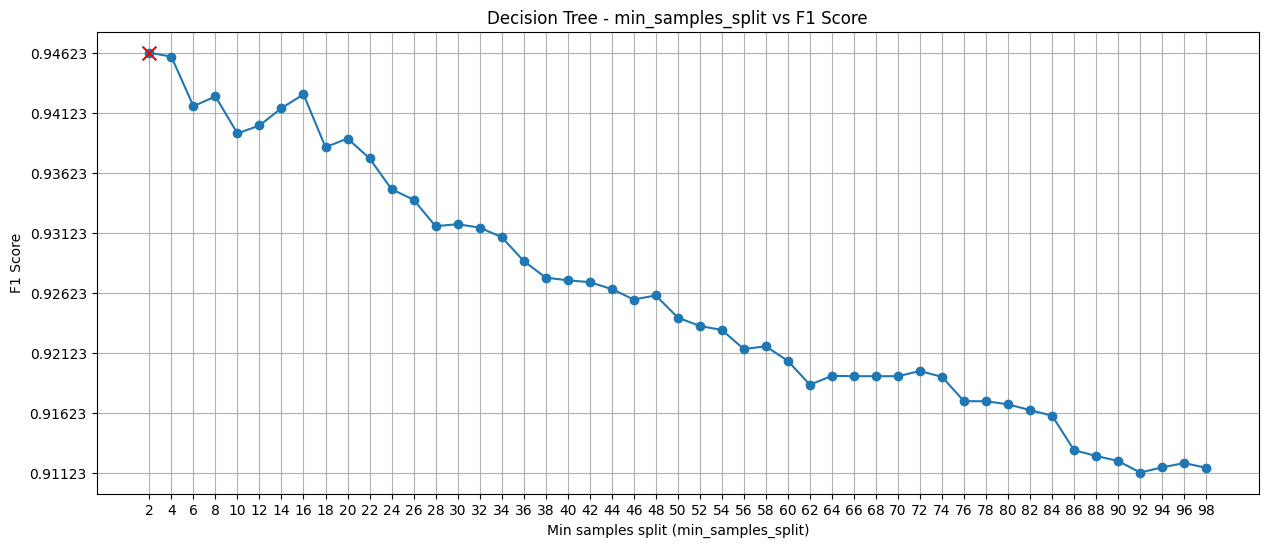

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

X = df.drop('Oscar Winners', axis=1)
y = df['Oscar Winners']

# Best Parameters for decision trees ======
min_samples_split = []
for i in range(1, 50):
    min_samples_split.append(2*i)
param_grid = {'min_samples_split': min_samples_split}
dt = DecisionTreeClassifier(criterion='entropy')
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=k, scoring='f1')
grid_search.fit(X, y)
best_dt_params = grid_search.best_params_

print(f"Best Decision Tree min_samples_split: {best_dt_params['min_samples_split']}")

all_params = list(ParameterGrid(param_grid))
scores = [grid_search.cv_results_['mean_test_score'][i] for i in range(len(all_params))]
best_dt_estimators = best_dt_params['min_samples_split']
best_f1_score = grid_search.best_score_
plt.figure(figsize=(15, 6))
plt.plot([param['min_samples_split'] for param in all_params], scores, marker='o')
plt.scatter(best_dt_estimators, best_f1_score, color='red', marker='x', s=100, zorder=3)
plt.title('Decision Tree - min_samples_split vs F1 Score')
plt.xlabel('Min samples split (min_samples_split)')
plt.ylabel('F1 Score')
plt.xticks(min_samples_split)
yt = np.linspace(min(scores), max(scores), 8)
plt.yticks(yt)
plt.grid(True)
plt.show()

Best Random Forest num_estimators: 10


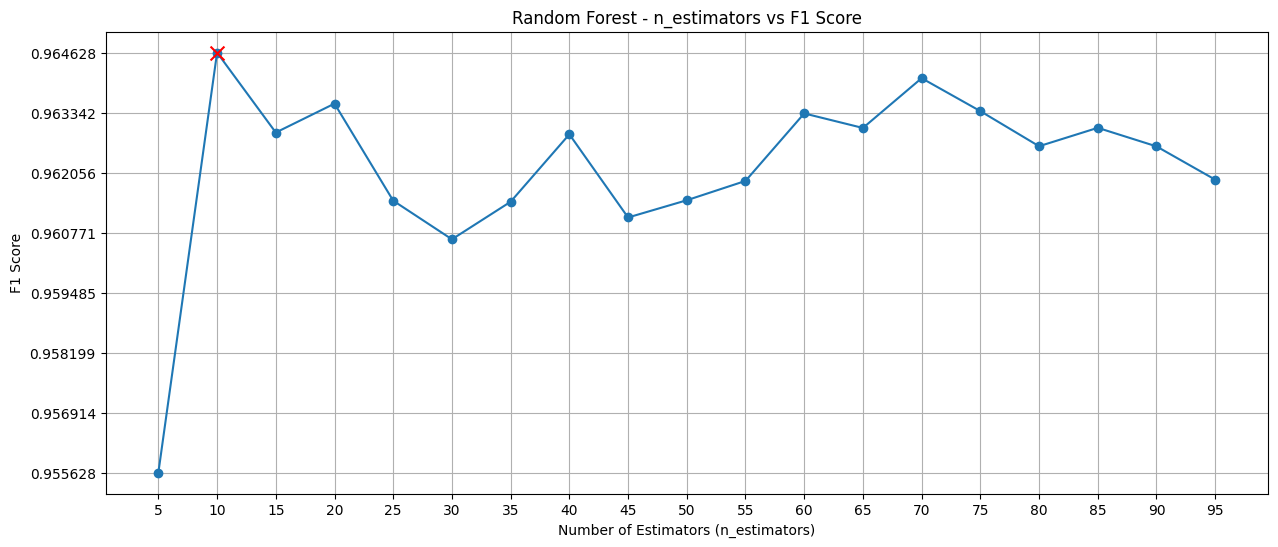

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

X = df.drop('Oscar Winners', axis=1)
y = df['Oscar Winners']

# Best Parameters for Random Forest =======
n_estimators = []
for i in range(1, 20):
    n_estimators.append(5*i)
param_grid = {'n_estimators': n_estimators}
rf = RandomForestClassifier(random_state=seed)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=k, scoring='f1')
grid_search.fit(X, y)
best_rf_params = grid_search.best_params_

print(f"Best Random Forest num_estimators: {best_rf_params['n_estimators']}")

all_params = list(ParameterGrid(param_grid))
scores = [grid_search.cv_results_['mean_test_score'][i] for i in range(len(all_params))]
best_n_estimators = best_rf_params['n_estimators']
best_f1_score = grid_search.best_score_
plt.figure(figsize=(15, 6))
plt.plot([param['n_estimators'] for param in all_params], scores, marker='o')
plt.scatter(best_n_estimators, best_f1_score, color='red', marker='x', s=100, zorder=3)
plt.title('Random Forest - n_estimators vs F1 Score')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('F1 Score')
plt.xticks(n_estimators)
yt = np.linspace(min(scores), max(scores), 8)
plt.yticks(yt)
plt.grid(True)
plt.show()

#### Comparing Different Models with best parameters:

Average Random Forest Fmeasure: 0.9623344471963433
Average Logistic Regression Fmeasure: 0.8916363396118518
Average Decision Tree Fmeasure: 0.9466681434379373


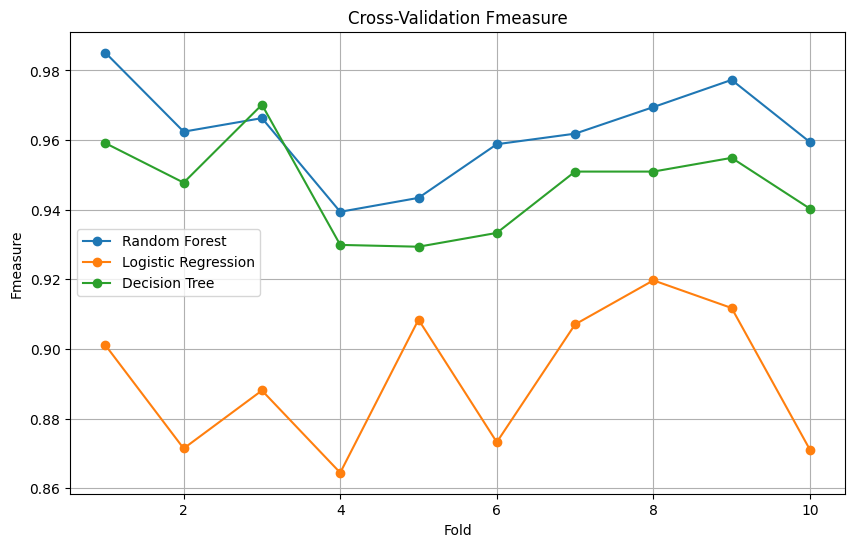

In [ ]:
rf_num_est, dt_min_samples = 10, 4

X = df.drop('Oscar Winners', axis=1)
y = df['Oscar Winners']

model_lr = LogisticRegression()
lr_mse_scores = cross_val_score(model_lr, X, y, cv=k, scoring='f1')
avg_lr_mse = np.mean(lr_mse_scores)

model_rt = RandomForestClassifier(n_estimators=rf_num_est, random_state=seed)
rt_mse_scores = cross_val_score(model_rt, X, y, cv=k, scoring='f1')
avg_rt_mse = np.mean(rt_mse_scores)

model_dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=dt_min_samples)
dt_mse_scores = cross_val_score(model_dt, X, y, cv=k, scoring='f1')
avg_dt_mse = np.mean(dt_mse_scores)

print(f"Average Random Forest Fmeasure: {avg_rt_mse}")
print(f"Average Logistic Regression Fmeasure: {avg_lr_mse}")
print(f"Average Decision Tree Fmeasure: {avg_dt_mse}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rt_mse_scores) + 1), rt_mse_scores, marker='o', label="Random Forest")
plt.plot(range(1, len(lr_mse_scores) + 1), lr_mse_scores, marker='o', label="Logistic Regression")
plt.plot(range(1, len(dt_mse_scores) + 1), dt_mse_scores, marker='o', label="Decision Tree")
plt.title('Cross-Validation Fmeasure')
plt.xlabel('Fold')
plt.ylabel('Fmeasure')
plt.grid(True)
plt.legend()
plt.show()

**Best method: Random Forest.**

Training / Testing Random Forest with best parameters:

In [ ]:
X = df.drop('Oscar Winners', axis=1)
y = df['Oscar Winners']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

model = RandomForestClassifier(n_estimators=75, random_state=seed)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))
print(f"Roc auc score {roc_auc_score(y_test, predictions)}")  # the bigger the better.
print(f'F1 Score: {f1_score(y_test, predictions)}')

Mean Squared Error: 0.02882205513784461
[[379  11]
 [ 12 396]]


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       390
           1       0.97      0.97      0.97       408

    accuracy                           0.97       798
   macro avg       0.97      0.97      0.97       798
weighted avg       0.97      0.97      0.97       798

Roc auc score 0.9711915535444947
F1 Score: 0.9717791411042945


# Part 3: Predicting with Anon Dataset

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
seed = 42

Preparing the dataset:

In [ ]:
df = pd.read_excel('/content/drive/My Drive/DataMining/moviesNew3.xlsx')

# df_test = pd.read_excel('/content/drive/My Drive/DataMining/movies_test _anon_sample.xlsx')
df_test = pd.read_excel('/content/drive/My Drive/DataMining/movies_test _anon.xlsx')
print(df_test.shape)

cols = list(df.columns)
cols.remove('Oscar Winners')
cols.append('ID')

combine_primary_genre(df_test)
df_test['Genre'] = df_test['Genre'].replace('-', np.nan)
df_test['Script Type'] = df_test['Script Type'].replace('-', np.nan)
most_frequent_genre = df_test['Genre'].mode()[0]
df_test['Genre'].fillna(most_frequent_genre, inplace=True)
most_frequent_script_type = df_test['Script Type'].mode()[0]
df_test['Script Type'].fillna(most_frequent_script_type, inplace=True)


df_test['Script Type'] = df_test['Script Type'].str.strip()
df_test['Script Type'] = df_test['Script Type'].str.replace(' ', '_')
df_test['Script Type'] = df_test['Script Type'].str.replace(",_", ' ')
get_dummies_genre(df_test, 'Script Type')

get_dummies_genre(df_test)


df_test['Distributor'] = df_test['Distributor'].str.replace(' ', '_')
df_test['Distributor'] = df_test['Distributor'].str.replace(",_", ' ')
get_dummies_genre(df_test, 'Distributor')

df_test['Distributor_sony_pictures_entertainment'] = df_test['Distributor_sony_pictures_entertainment_(spe)']
df_test['Distributor_lionsgate_films'] = df_test['Distributor_lionsgate']
df_test['Distributor_summit_media'] = df_test['Distributor_summit_entertainment']
df_test.drop(columns=['Distributor_lionsgate', 'Distributor_sony_pictures_entertainment_(spe)', 'Distributor_summit_entertainment'], inplace=True)


# fills out the missing (one-hot) columns with 0s.
missing_columns = set(cols) - set(df_test.columns)
for col in missing_columns:
    df_test[col] = 0

# Create Budget Column:
df_test["Budget ($million)"] = df_test["Budget ($million)"].replace('-', np.nan)
df_test["Budget ($million)"] = pd.to_numeric(df_test["Budget ($million)"])
df_test["Budget"] = df_test["Budget ($million)"] * 1_000_000
df_test.drop(columns=['Budget ($million)'], inplace=True)

df_test['Metacritic  critics'] = df_test['Metacritic  critics'].replace('-', np.nan)
df_test['Average critics '] = df_test['Average critics '].replace('-', np.nan)
df_test['Rotten Tomatoes vs Metacritic  deviance'] = df_test['Rotten Tomatoes vs Metacritic  deviance'].replace('-', np.nan)
df_test['Opening Weekend'] = df_test['Opening Weekend'].replace('-', np.nan)


df_test['Rotten Tomatoes  critics'] = df_test['Rotten Tomatoes  critics'].replace('-', np.nan)

df_test['Average audience '] = df_test['Average audience '].replace('-', np.nan)
df_test['Metacritic Audience '] = df_test['Metacritic Audience '].replace('-', np.nan)

df_test[' Budget recovered'] = df_test[' Budget recovered'].replace('-', np.nan)
df_test[' Budget recovered'] = df_test[' Budget recovered'].replace('#VALUE!', np.nan)
df_test[' Budget recovered'] = pd.to_numeric(df_test[' Budget recovered'].replace('%', '', regex=True))

df_test[' Budget recovered opening weekend'] = df_test[' Budget recovered opening weekend'].replace('-', np.nan)
df_test[' Budget recovered opening weekend'] = pd.to_numeric(df_test[' Budget recovered opening weekend'].replace('%', '', regex=True))


df_test['Audience vs Critics deviance '] = df_test['Audience vs Critics deviance '].replace('-', np.nan)
df_test['Foreign Gross'] = df_test['Foreign Gross'].replace('-', np.nan)
df_test['Domestic Gross'] = df_test['Domestic Gross'].replace('-', np.nan)
df_test[' of Gross earned abroad'] = df_test[' of Gross earned abroad'].replace('-', np.nan)
df_test['Worldwide Gross'] = df_test['Worldwide Gross'].replace('-', np.nan)

df_test['Foreign Gross'] = pd.to_numeric(df_test["Foreign Gross"].replace(',', '', regex=True))
df_test[' of Gross earned abroad'] = pd.to_numeric(df_test[" of Gross earned abroad"].replace('%', '', regex=True))


diff = df_test['Average audience '] - df_test['IMDb Rating'] * 10
mean_difference = diff.mean()
print("Mean IMDB vs RT disparity:", mean_difference)
missing_imdb = df_test[df_test['IMDb Rating'].isnull()]
missing_imdb['IMDb Rating'] = (missing_imdb['Average audience '] - mean_difference) / 10
df_test.update(missing_imdb)

missing_rt_critics = df_test[df_test['Rotten Tomatoes  critics'].isnull()]
missing_rt_critics['Rotten Tomatoes  critics'] = missing_rt_critics['Average critics ']
df_test.update(missing_rt_critics)


numeric_cols = df_test.select_dtypes(include=[np.number]).columns
df_test[numeric_cols] = df_test[numeric_cols].fillna(df_test[numeric_cols].mean())

df_test = df_test[cols]


df_test.to_excel('/content/drive/My Drive/DataMining/movies_test _anon2.xlsx', index=False)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols = list(df_test.columns)
cols.remove('ID')
for c in cols:
    # print(c)
    df_test[[c]] = scaler.fit_transform(df_test[[c]])

print(df_test.shape)
print(list(df_test.columns))

missing_data = df_test.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df_test.shape[0]) * 100
missing_percentage.sort_values(ascending=True, inplace=True)
print(missing_percentage)

df_test['ID'] = df_test['ID'].astype(int) # converts IDs back to int.

(565, 31)
Mean IMDB vs RT disparity: 3.1989150090415914
(565, 14)
['Average critics ', 'Metacritic  critics', 'IMDb Rating', 'Rotten Tomatoes Audience ', 'Rotten Tomatoes  critics', 'Script Type_based_on_a_true_story', 'Genre_history', 'Genre_biography', 'Genre_drama', 'Genre_animation', 'Distributor_pixar_animation_studios', 'Distributor_summit_media', 'Distributor_fox_searchlight', 'ID']
Series([], dtype: float64)


Training the model with all available training data:

In [ ]:
X_train = df.drop('Oscar Winners', axis=1)
y_train = df['Oscar Winners']

model = RandomForestClassifier(n_estimators=10, random_state=seed)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

Predicting oscar winners with anon sample dataset:

In [ ]:
X_test = df_test.drop('ID', axis=1)

X_test = X_test[X_train.columns]  # takes the same columns as X_train (in the same order).

predictions = model.predict(X_test)

probability_scores = model.predict_proba(X_test)
probability_oscars = probability_scores[:, 1]

df_test['Oscar Winners'] = predictions

oscar_winners = df_test[df_test['Oscar Winners'] == 1]
# Print the relevant columns
print(oscar_winners[["ID", "Oscar Winners"]].to_string(index=False))

print("Average Correct Oscar Movies Probability:", np.mean(probability_oscars))

 ID  Oscar Winners
 13              1
 20              1
 31              1
 38              1
 45              1
 49              1
 52              1
 59              1
 80              1
103              1
105              1
111              1
114              1
133              1
141              1
142              1
143              1
147              1
149              1
167              1
173              1
196              1
204              1
206              1
223              1
240              1
249              1
257              1
279              1
281              1
282              1
289              1
306              1
308              1
322              1
334              1
344              1
370              1
371              1
406              1
413              1
415              1
424              1
451              1
466              1
469              1
471              1
476              1
484              1
485              1
499              1
504         

Save the results:

In [ ]:
df_test = df_test[['ID', 'Oscar Winners']]
df_test.rename(columns={'Oscar Winners': 'OSCAR'}, inplace=True)
df_test.to_csv("/content/drive/My Drive/DataMining/predictions.csv", index=False)

# Part 4: Clustering

Prepare data:

In [ ]:
import pandas as pd

df = pd.read_excel('/content/drive/My Drive/DataMining/moviesNew3.xlsx')
X = df
y = df['Oscar Winners']
seed = 42

# PCA:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X = pca.fit(X).transform(X)
dfpca =pd.DataFrame(X,columns=['PC1','PC2'])

df = pd.concat([dfpca, y],axis=1)

# reduced_data = X
df

PC1       PC2  Oscar Winners
0    -0.396795 -0.361047              1
1     0.624471 -0.069235              0
2     0.508264 -0.104513              0
3    -0.428349 -0.369477              1
4     0.369827 -0.146823              0
...        ...       ...            ...
2655 -0.795150  0.363129              1
2656 -0.714661  0.019592              1
2657  0.319308  0.687004              0
2658  0.313770 -0.156610              0
2659 -0.005832  1.133316              0

[2660 rows x 3 columns]

Plot the data:

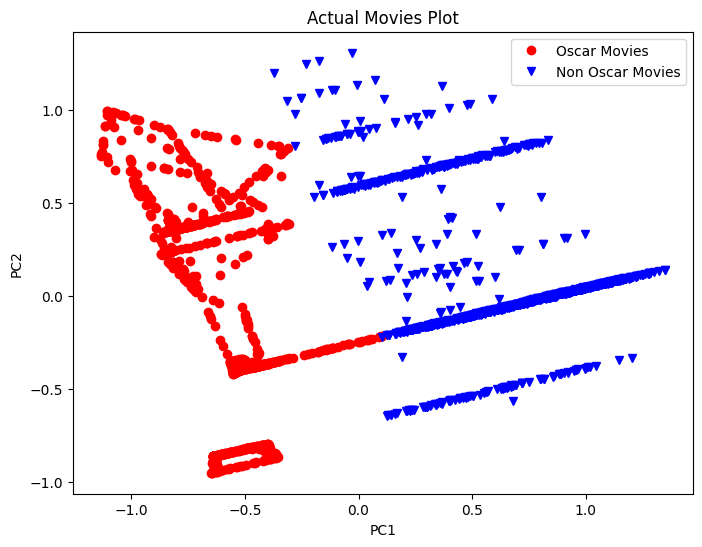

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_actual_movies(df):
    df0=df[df['Oscar Winners']==0]
    df1=df[df['Oscar Winners']==1]
    plt.plot(df1[["PC1"]], df1[["PC2"]],'ro',label="Oscar Movies")
    plt.plot(df0[["PC1"]], df0[["PC2"]],'bv',label="Non Oscar Movies")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title('Actual Movies Plot')
    plt.legend()

plt.figure(figsize=(8, 6))
plot_actual_movies(df)
plt.show()

Function that prints the scores:

In [ ]:
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score

def print_cluster_scores(df, X, labels, print_davies=False):
  sil = metrics.silhouette_score(X, labels, metric='euclidean')
  fms_score = metrics.fowlkes_mallows_score(df['Oscar Winners'], labels)
  davies = metrics.davies_bouldin_score(X, labels)
  print("Silhouete Score:", sil)
  ari = adjusted_rand_score(df['Oscar Winners'], labels)
  print(f"Adjusted Rand Index (ARI): {ari}")
  print("Fowlkes-Mallows Score:", fms_score)
  if print_davies:
      print("Davies_bouldin Score:", davies)

Ισχύουν τα παρακάτω για την επιλογή του κατάλληλου αριθμού clusters:
* Όσο ψηλότερο το silouette, τόσο το καλύτερο.
* Όσο ψηλότερο το fowlkes_mallows, τόσο το καλύτερο.
* Όσο ψηλότερο το davies_bouldin, τόσο το χειρότερο.

Πηγή: https://generativeai.pub/how-to-choose-the-right-clustering-algorithm-for-your-data-8f3ee24b9c16

## K-Means:

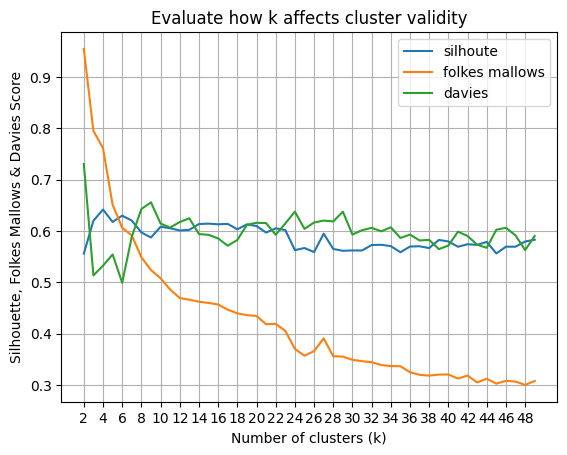

In [ ]:
import sklearn
from sklearn import metrics
from sklearn.cluster import KMeans

xs=range(2,50)
xs_ticks=range(2, 50, 2)
sils=[]
fms=[]
dbs=[]

for i in xs:
    kclu=KMeans(n_clusters=i, random_state=seed)
    kclu.fit(X)
    sils.append(metrics.silhouette_score(X, kclu.labels_, metric='euclidean'))
    fms.append(metrics.fowlkes_mallows_score(df['Oscar Winners'], kclu.labels_))
    dbs.append(metrics.davies_bouldin_score(X, kclu.labels_))
# print(list(xs))
# print(sils)
# print(fms)
plt.plot(xs,sils)
plt.plot(xs,fms)
plt.plot(xs,dbs)
plt.xticks(xs_ticks)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette, Folkes Mallows & Davies Score')
plt.title('Evaluate how k affects cluster validity')
plt.legend(['silhoute','folkes mallows', 'davies'])
plt.grid()
plt.show()

Από το γράφημα, μπορούμε να δούμε ότι η καλύτερη τιμή είναι **k = 4**. Αυτό καθώς έχει το μεγαλύτερο silhouette, υψηλό folkes mallows και σχετικά χαμηλό davies.

Silhouete Score: 0.6416936239623586
Adjusted Rand Index (ARI): 0.5793397831624262
Fowlkes-Mallows Score: 0.7611292608123397


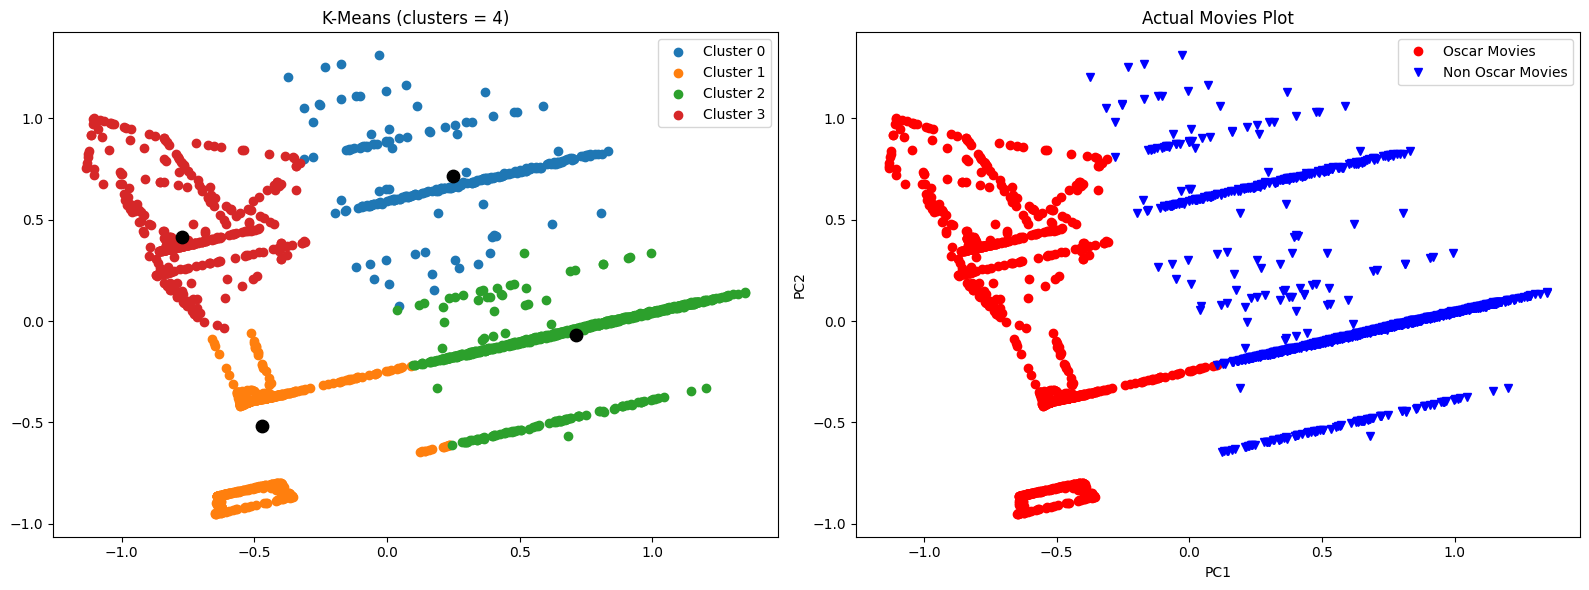

In [ ]:
clusters = 4
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# pca = PCA(n_components=2)
# reduced_data = pca.fit_transform(df.values)

kmeans = KMeans(n_clusters=clusters)
labels = kmeans.fit_predict(X)

print_cluster_scores(df, X, labels)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for i in range(clusters):
  plt.scatter(X[labels == i, 0], X[labels == i, 1], label=f'Cluster {i}')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.title(f'K-Means (clusters = {clusters})')
plt.legend()
plt.subplot(1, 2, 2)
plot_actual_movies(df)
plt.tight_layout()
plt.show()

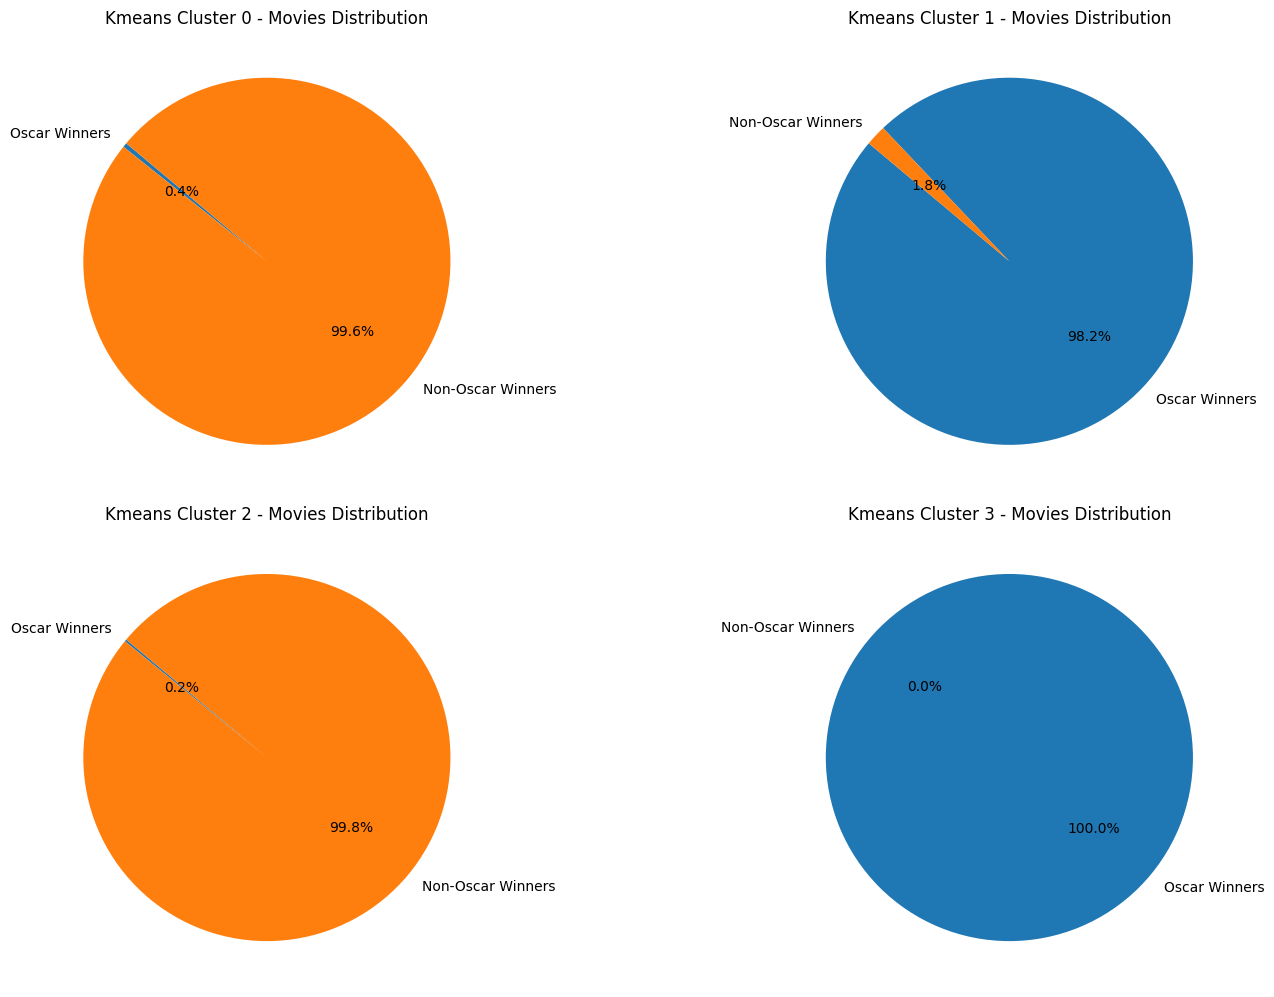

In [ ]:
import matplotlib.pyplot as plt
import copy

df_cluster = copy.deepcopy(df)
df_cluster['Clusters'] = labels

num_clusters = len(df_cluster['Clusters'].unique())

plt.figure(figsize=(15, 5 * num_clusters))
for i in range(num_clusters):
    cluster_data = df_cluster[df_cluster['Clusters'] == i]

    oscar_winners_percentage = (cluster_data['Oscar Winners'] == 1).mean() * 100

    plt.subplot(num_clusters, 2, i + 1)
    plt.pie([oscar_winners_percentage, 100 - oscar_winners_percentage],
            labels=['Oscar Winners', 'Non-Oscar Winners'], autopct='%1.1f%%', startangle=140)
    plt.title(f'Kmeans Cluster {i} - Movies Distribution')

plt.tight_layout()
plt.show()


Oscar Winners Clusters%
1    52.857143
3    46.917293
2     0.150376
0     0.075188
Name: Clusters, dtype: float64
Non Oscar Winners Clusters%
2    79.699248
0    19.323308
1     0.977444
Name: Clusters, dtype: float64


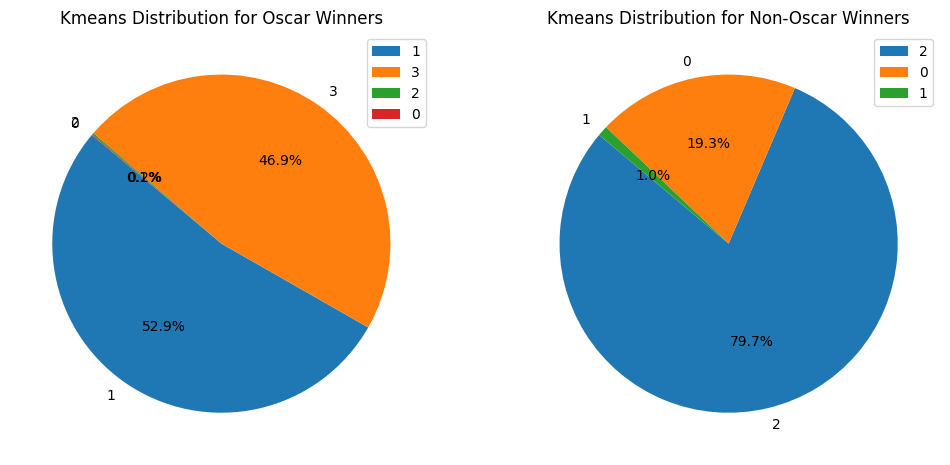

In [ ]:
import matplotlib.pyplot as plt
import copy

df_cluster = copy.deepcopy(df)
df_cluster['Clusters'] = labels

oscar_winners = df_cluster[df_cluster['Oscar Winners'] == 1]
non_oscar_winners = df_cluster[df_cluster['Oscar Winners'] == 0]

oscar_winners_clusters = oscar_winners['Clusters']
oscar_cluster_percentages = oscar_winners_clusters.value_counts(normalize=True) * 100
print("Oscar Winners Clusters%")
print(oscar_cluster_percentages)

non_oscar_winners_clusters = non_oscar_winners['Clusters']
non_oscar_cluster_percentages = non_oscar_winners_clusters.value_counts(normalize=True) * 100
print("Non Oscar Winners Clusters%")
print(non_oscar_cluster_percentages)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(oscar_cluster_percentages, labels=oscar_cluster_percentages.index, autopct='%1.1f%%', startangle=140)
plt.title('Kmeans Distribution for Oscar Winners')
plt.legend()

plt.subplot(1, 2, 2)
plt.pie(non_oscar_cluster_percentages, labels=non_oscar_cluster_percentages.index, autopct='%1.1f%%', startangle=140)
plt.title('Kmeans Distribution for Non-Oscar Winners')

plt.legend()
plt.show()


## HAC:

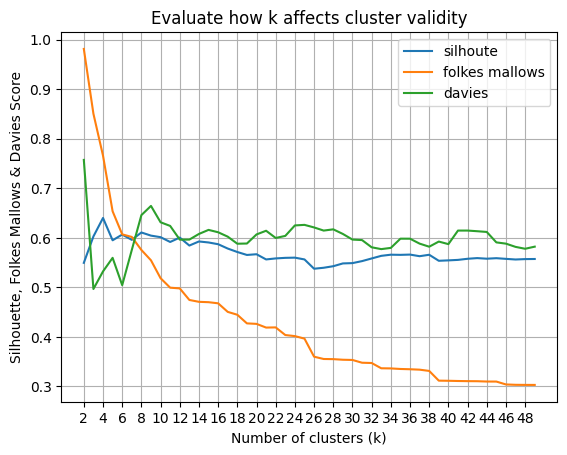

In [ ]:
import sklearn
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

xs=range(2,50)
xs_ticks=range(2, 50, 2)

sils=[]
fms=[]
dbs=[]

for i in xs:
    haclu=AgglomerativeClustering(n_clusters=i, linkage='ward')
    haclu.fit(X)
    sils.append(metrics.silhouette_score(X, haclu.labels_, metric='euclidean'))
    fms.append(metrics.fowlkes_mallows_score(df['Oscar Winners'], haclu.labels_))
    dbs.append(metrics.davies_bouldin_score(X, haclu.labels_))
# print(list(xs))
# print(sils)
# print(fms)
plt.plot(xs,sils)
plt.plot(xs,fms)
plt.plot(xs,dbs)
plt.xticks(xs_ticks)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette, Folkes Mallows & Davies Score')
plt.title('Evaluate how k affects cluster validity')
plt.legend(['silhoute','folkes mallows', 'davies'])
plt.grid()
plt.show()

Από το γράφημα, μπορούμε να δούμε ότι η καλύτερη τιμή είναι **k = 4**. Αυτό καθώς έχει το μεγαλύτερο silhouette, υψηλό folkes mallows και σχετικά χαμηλό davies.

Silhouete Score: 0.6400645055001494
Adjusted Rand Index (ARI): 0.5865672567916242
Fowlkes-Mallows Score: 0.7658883670748172


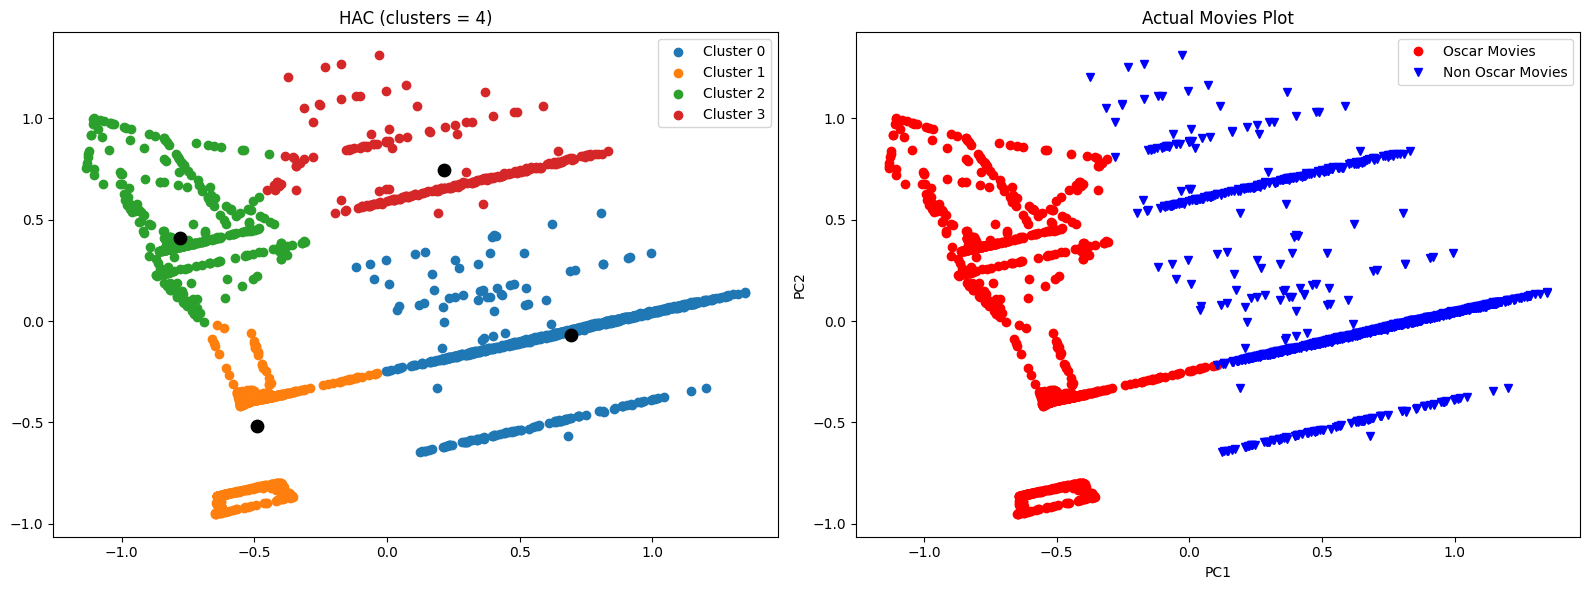

In [ ]:
clusters = 4

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestCentroid

# pca = PCA(n_components=2)
# reduced_data = pca.fit_transform(df.values)

haclu = AgglomerativeClustering(n_clusters=clusters, linkage='ward')
labels = haclu.fit_predict(X)

print_cluster_scores(df, X, labels)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for i in range(clusters):
  plt.scatter(X[labels == i, 0], X[labels == i, 1], label=f'Cluster {i}')
clf = NearestCentroid()
clf.fit(X, labels)
centroids = clf.centroids_
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.title(f'HAC (clusters = {clusters})')
plt.legend()
plt.subplot(1, 2, 2)
plot_actual_movies(df)
plt.tight_layout()
plt.legend()
plt.show()

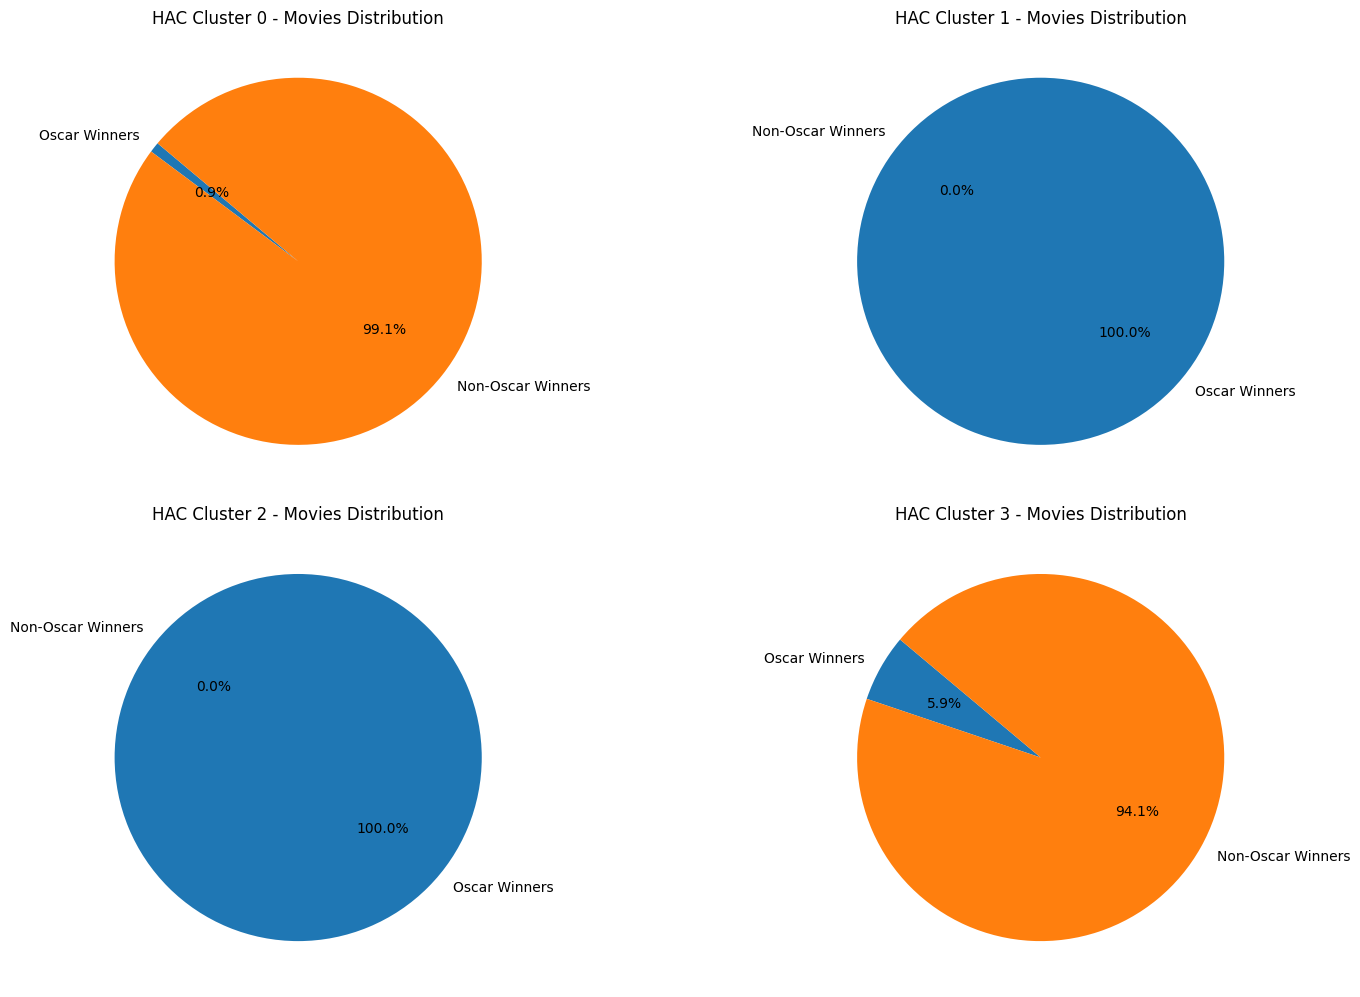

In [ ]:
import matplotlib.pyplot as plt
import copy

df_cluster = copy.deepcopy(df)
df_cluster['Clusters'] = labels

num_clusters = len(df_cluster['Clusters'].unique())

plt.figure(figsize=(15, 5 * num_clusters))
for i in range(num_clusters):
    cluster_data = df_cluster[df_cluster['Clusters'] == i]

    oscar_winners_percentage = (cluster_data['Oscar Winners'] == 1).mean() * 100

    plt.subplot(num_clusters, 2, i + 1)
    plt.pie([oscar_winners_percentage, 100 - oscar_winners_percentage],
            labels=['Oscar Winners', 'Non-Oscar Winners'], autopct='%1.1f%%', startangle=140)
    plt.title(f'HAC Cluster {i} - Movies Distribution')

plt.tight_layout()
plt.show()


Oscar Winners Clusters%
1    52.406015
2    45.714286
3     1.127820
0     0.751880
Name: Clusters, dtype: float64
Non Oscar Winners Clusters%
0    82.105263
3    17.894737
Name: Clusters, dtype: float64


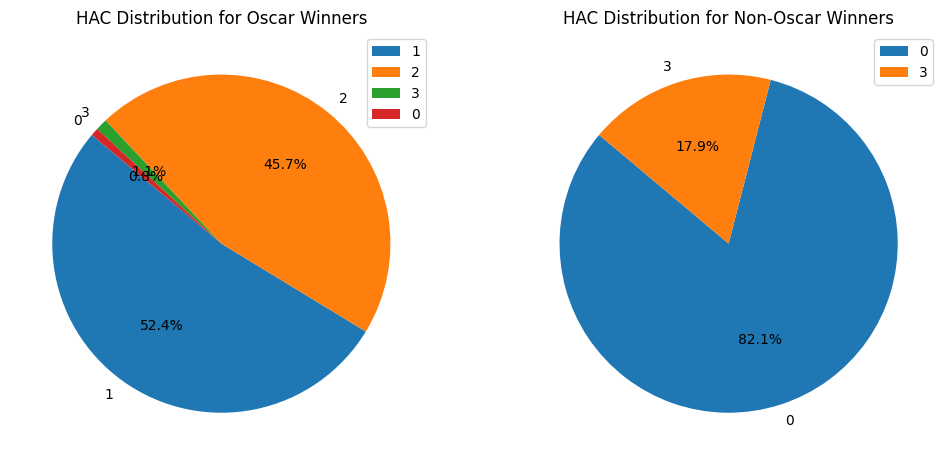

In [ ]:
import matplotlib.pyplot as plt
import copy

df_cluster = copy.deepcopy(df)
df_cluster['Clusters'] = labels

oscar_winners = df_cluster[df_cluster['Oscar Winners'] == 1]
non_oscar_winners = df_cluster[df_cluster['Oscar Winners'] == 0]

oscar_winners_clusters = oscar_winners['Clusters']
oscar_cluster_percentages = oscar_winners_clusters.value_counts(normalize=True) * 100
print("Oscar Winners Clusters%")
print(oscar_cluster_percentages)

non_oscar_winners_clusters = non_oscar_winners['Clusters']
non_oscar_cluster_percentages = non_oscar_winners_clusters.value_counts(normalize=True) * 100
print("Non Oscar Winners Clusters%")
print(non_oscar_cluster_percentages)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(oscar_cluster_percentages, labels=oscar_cluster_percentages.index, autopct='%1.1f%%', startangle=140)
plt.title('HAC Distribution for Oscar Winners')
plt.legend()

plt.subplot(1, 2, 2)
plt.pie(non_oscar_cluster_percentages, labels=non_oscar_cluster_percentages.index, autopct='%1.1f%%', startangle=140)
plt.title('HAC Distribution for Non-Oscar Winners')

plt.legend()
plt.show()


## DBSCAN:

In [ ]:
!pip install kneed > /dev/null 2>&1

0.14081966386036457


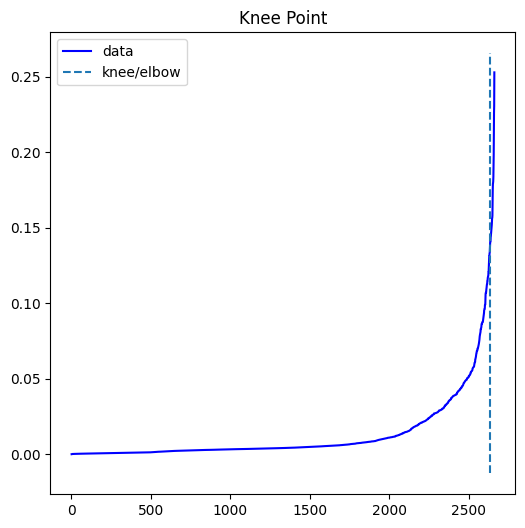

In [ ]:
import sklearn
from sklearn import metrics
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

min_samples = 2 * X.shape[1]

nbrs = NearestNeighbors(n_neighbors = min_samples+1).fit(X)
neigh_dist, neigh_ind = nbrs.kneighbors(X)
sort_neigh_dist = np.sort(neigh_dist, axis = 0)

k_dist = sort_neigh_dist[:, min_samples]

# plt.plot(k_dist)
# plt.ylabel("k-NN distance")
# plt.xlabel(f"Sorted observations ({min_samples}th NN)")
# plt.show()

from kneed import KneeLocator
kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0,
                      curve = "concave", direction = "increasing", online=True)

# get the estimate of knee point
print(kneedle.knee_y)
kneedle.plot_knee()
plt.show()

To knee point είναι στο 0.14 άρα το e = 0.14, ενώ το min_samples είναι 2 * αριθμός features (προτείνεται να είναι έτσι).

Πηγές: [1](https://www.reneshbedre.com/blog/dbscan-python.html), [2](https://www.section.io/engineering-education/dbscan-clustering-in-python/)

Number of clusters: 7
Silhouete Score: -0.1820774640078261
Adjusted Rand Index (ARI): 0.02824118839207375
Fowlkes-Mallows Score: 0.5854114173823263


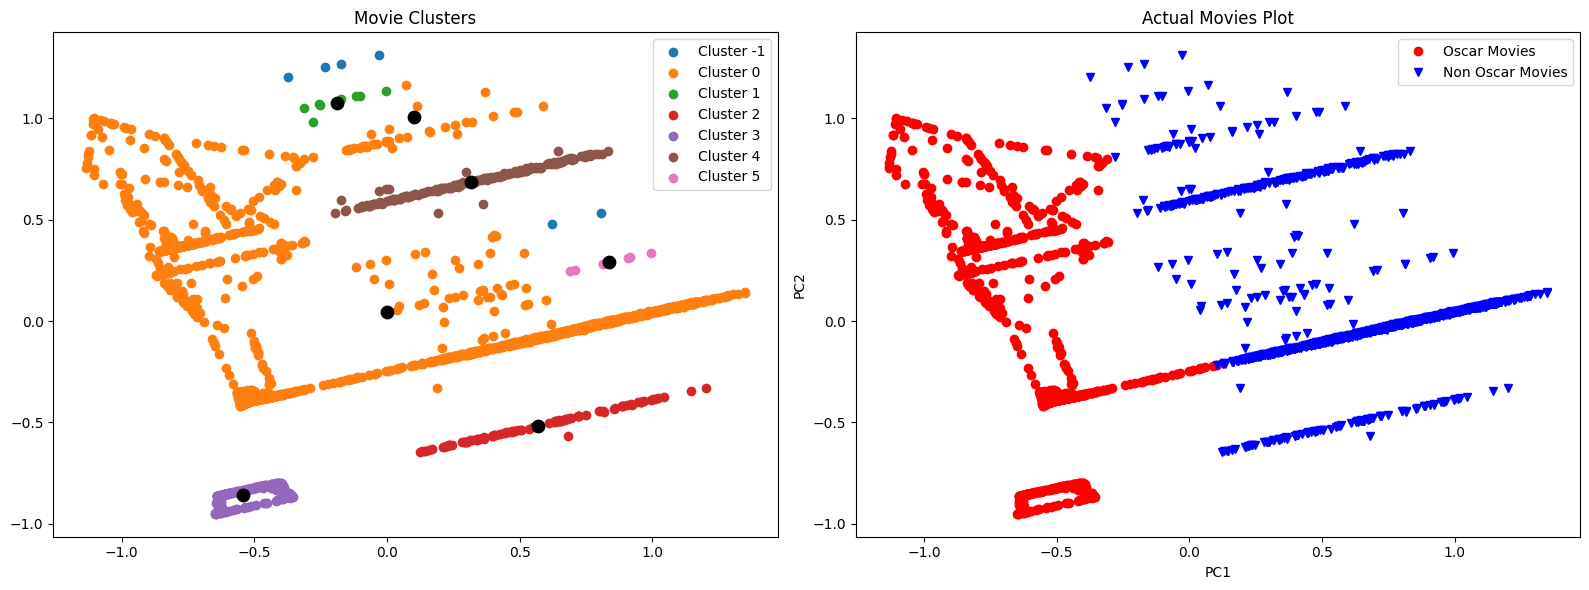

In [ ]:
from sklearn.cluster import DBSCAN
clusters = DBSCAN(eps = 0.14, min_samples = 2*X.shape[1]).fit(X)
labels = clusters.labels_

num_clusters = len(np.unique(labels))
print(f"Number of clusters: {num_clusters}")

print_cluster_scores(df, X, labels)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for i in range(-1, num_clusters - 1):
  plt.scatter(X[labels == i, 0], X[labels == i, 1], label=f'Cluster {i}')
clf = NearestCentroid()
clf.fit(X, labels)
centroids = clf.centroids_
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.title('Movie Clusters')
plt.legend()
plt.subplot(1, 2, 2)
plot_actual_movies(df)
plt.tight_layout()
plt.legend()
plt.show()

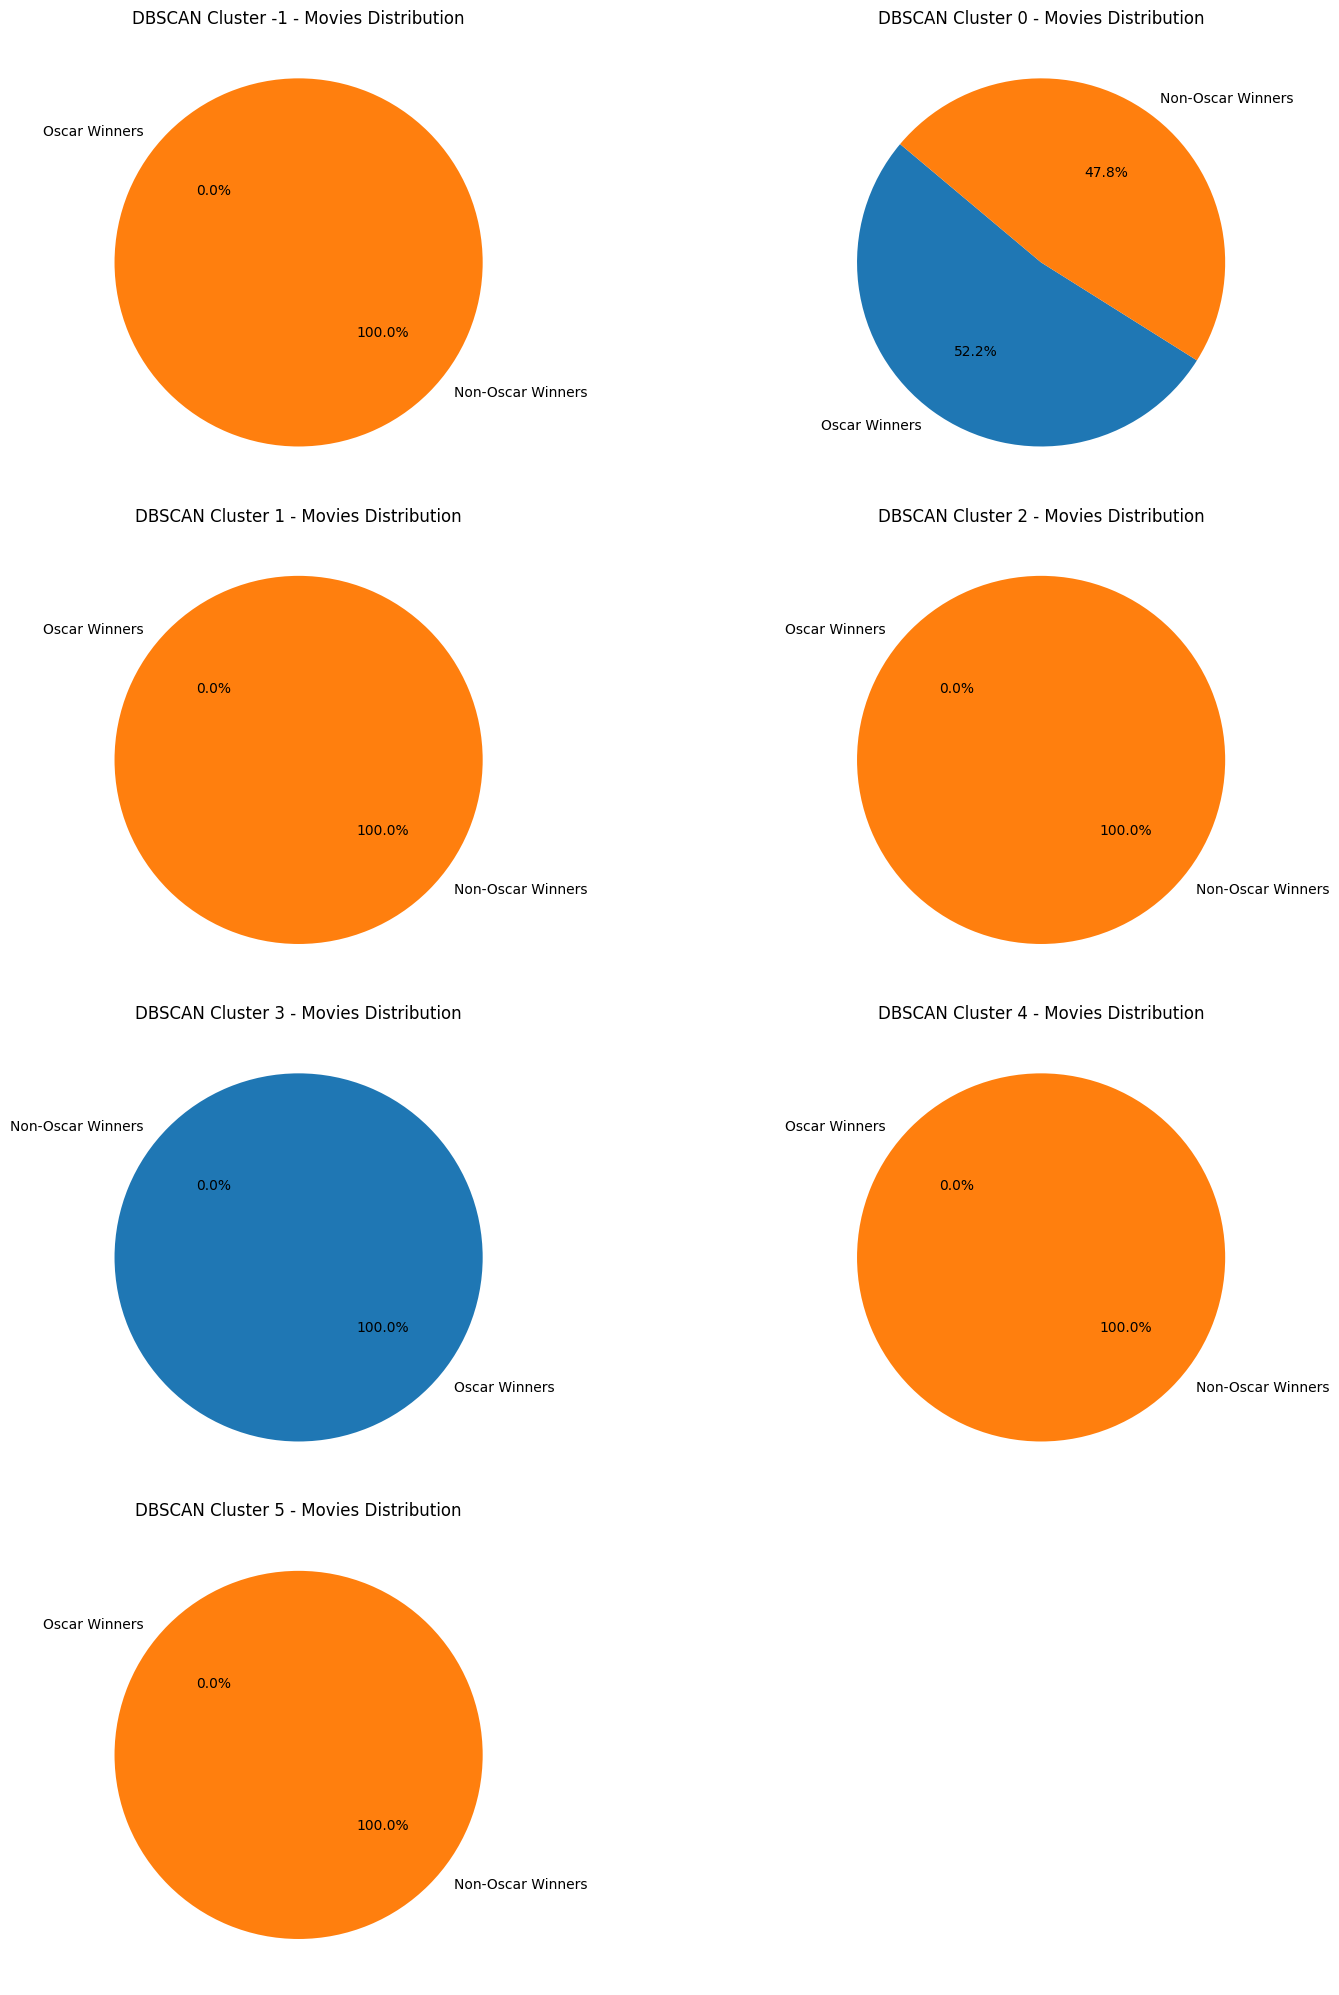

In [ ]:
import matplotlib.pyplot as plt
import copy

df_cluster = copy.deepcopy(df)
df_cluster['Clusters'] = labels

num_clusters = len(df_cluster['Clusters'].unique()) - 1

plt.figure(figsize=(15, 5 * num_clusters))
for i in range(-1, num_clusters):
    cluster_data = df_cluster[df_cluster['Clusters'] == i]

    oscar_winners_percentage = (cluster_data['Oscar Winners'] == 1).mean() * 100

    plt.subplot(num_clusters, 2, i + 2)
    plt.pie([oscar_winners_percentage, 100 - oscar_winners_percentage],
            labels=['Oscar Winners', 'Non-Oscar Winners'], autopct='%1.1f%%', startangle=140)
    plt.title(f'DBSCAN Cluster {i} - Movies Distribution')

plt.tight_layout()
plt.show()


Oscar Winners Clusters%
0    83.759398
3    16.240602
Name: Clusters, dtype: float64
Non Oscar Winners Clusters%
 0    76.766917
 4    14.135338
 2     7.518797
 1     0.601504
 5     0.526316
-1     0.451128
Name: Clusters, dtype: float64


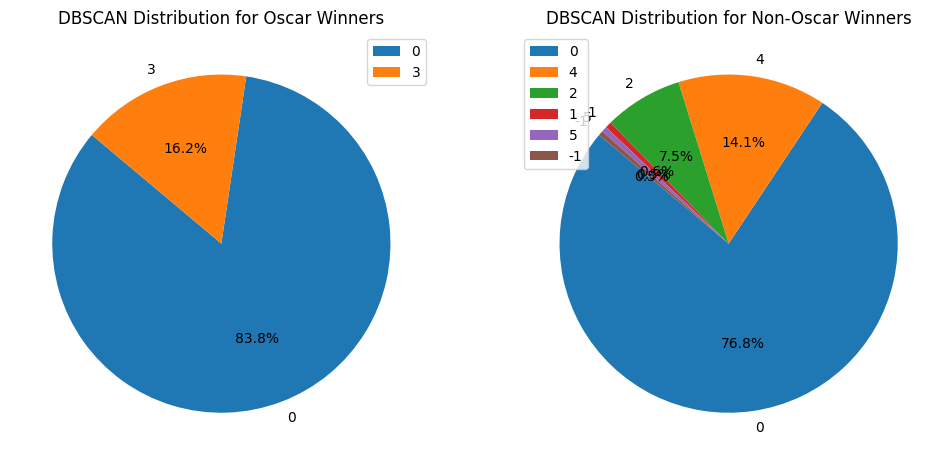

In [ ]:
import matplotlib.pyplot as plt
import copy

df_cluster = copy.deepcopy(df)
df_cluster['Clusters'] = labels

oscar_winners = df_cluster[df_cluster['Oscar Winners'] == 1]
non_oscar_winners = df_cluster[df_cluster['Oscar Winners'] == 0]

oscar_winners_clusters = oscar_winners['Clusters']
oscar_cluster_percentages = oscar_winners_clusters.value_counts(normalize=True) * 100
print("Oscar Winners Clusters%")
print(oscar_cluster_percentages)

non_oscar_winners_clusters = non_oscar_winners['Clusters']
non_oscar_cluster_percentages = non_oscar_winners_clusters.value_counts(normalize=True) * 100
print("Non Oscar Winners Clusters%")
print(non_oscar_cluster_percentages)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(oscar_cluster_percentages, labels=oscar_cluster_percentages.index, autopct='%1.1f%%', startangle=140)
plt.title('DBSCAN Distribution for Oscar Winners')
plt.legend()

plt.subplot(1, 2, 2)
plt.pie(non_oscar_cluster_percentages, labels=non_oscar_cluster_percentages.index, autopct='%1.1f%%', startangle=140)
plt.title('DBSCAN Distribution for Non-Oscar Winners')

plt.legend()
plt.show()


## Results:

**KMEANS**<br>
Clusters: 4<br>
Silhouete Score: 0.6416936239622132<br>
Adjusted Rand Index (ARI): 0.5793397831624262<br>
Fowlkes-Mallows Score: 0.7611292608123397

---
**HAC**<br>
Clusters: 4<br>
Silhouete Score: 0.6400645055002222<br>
Adjusted Rand Index (ARI): 0.5865672567916242<br>
Fowlkes-Mallows Score: 0.7658883670748172

---
**DBSCAN**
Clusters: 7<br>
Silhouete Score: -0.1820774640078261<br>
Adjusted Rand Index (ARI): 0.02824118839207375<br>
Fowlkes-Mallows Score: 0.5854114173823263


Plot the results:

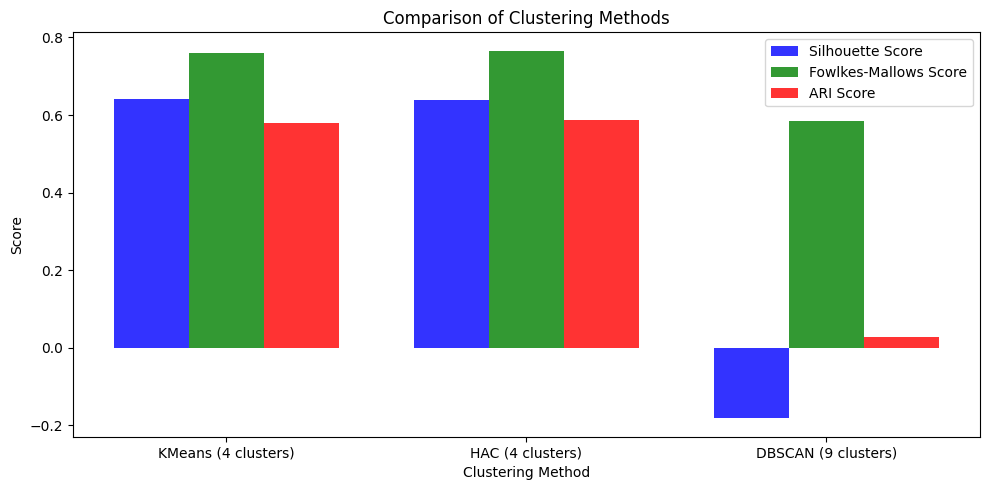

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the clustering methods and their scores
methods = ['KMeans (4 clusters)', 'HAC (4 clusters)', 'DBSCAN (9 clusters)']
silhouette_scores = [0.6416936239622132, 0.6400645055002222, -0.1820774640078261]
fowlkes_mallows_scores = [0.7611292608123397, 0.7658883670748172, 0.5854114173823263]
ari_scores = [0.5793397831624262, 0.5865672567916242, 0.02824118839207375]

bar_width = 0.25
opacity = 0.8
index = np.arange(len(methods))

plt.figure(figsize=(10, 5))
plt.bar(index, silhouette_scores, bar_width, alpha=opacity, color='b', label='Silhouette Score')
plt.bar(index + bar_width, fowlkes_mallows_scores, bar_width, alpha=opacity, color='g', label='Fowlkes-Mallows Score')
plt.bar(index + 2*bar_width, ari_scores, bar_width, alpha=opacity, color='r', label='ARI Score')

plt.xlabel('Clustering Method')
plt.ylabel('Score')
plt.title('Comparison of Clustering Methods')
plt.xticks(index + bar_width, methods)
plt.legend()

plt.tight_layout()
plt.show()


Το καλύτερο "διαχωρισμό" των δεδομένων το δίνει το silhouette score. Όσο ψηλότερο είναι τόσο καλύτερα είναι διαχωρισμένα τα δεδομένα στα clusters.

Το fowlkes-mallows από την άλλη δείχνει πόσο καλά ταίριαξαν τα clusters με τις αρχικές προβλέψεις. Όσο ψηλότερο είναι το fowlkes-mallows, τόσο καλύτερα ταίριαξαν τα clusters στις αρχικές προβλέψεις.